In [1]:
%load_ext autoreload
%autoreload 2

# Use HuggingFace's datasets library to access the Emotion dataset
from datasets import load_dataset, concatenate_datasets
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from gensim.models import word2vec
from gensim.utils import tokenize
import gensim.downloader
from gensim.corpora import Dictionary
from transformers import TrainerCallback
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import AutoTokenizer
from torch import nn
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold
import optuna
import random

In [2]:
from pytorch_lightning import seed_everything

seed_everything(10)
random.seed(10)
np.random.seed(10)
torch.manual_seed(10)

Seed set to 10


In [3]:
cache_dir = "./data_cache"

train_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="train",
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset)} instances loaded")


val_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="validation",
    cache_dir=cache_dir,
)
print(f"Development/validation dataset with {len(val_dataset)} instances loaded")


test_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="test",
    cache_dir=cache_dir,
)

print(f"Test dataset with {len(test_dataset)} instances loaded")

# Access the input text and target labels like this...
train_texts = train_dataset['text']
train_labels = train_dataset['label']

val_texts = val_dataset['text']
val_labels = val_dataset['label']

test_texts = test_dataset['text']
test_labels = test_dataset['label']

Training dataset with 3257 instances loaded
Development/validation dataset with 374 instances loaded
Test dataset with 1421 instances loaded


# Find max_length of doc

In [4]:
def tok_text(sample):
    sample["tokens"] = list(tokenize(sample['text']))
    return sample

tok_train_dataset = train_dataset.map(tok_text)

tok_train_dataset

Dataset({
    features: ['text', 'label', 'tokens'],
    num_rows: 3257
})

In [5]:
dictionary = Dictionary(tok_train_dataset["tokens"]) # construct word<->id mappings
print(dictionary)
def encode_text(sample):
    input_ids = []
    for token in sample["tokens"]:
        if token in dictionary.token2id:
            input_ids.append(dictionary.token2id[token] + 1)
    sample['input_ids'] = input_ids 
    return sample

pre_train_dataset = tok_train_dataset.map(encode_text)
len(pre_train_dataset)  

Dictionary<9310 unique tokens: ['Joyce', 'Meyer', 'Worry', 'a', 'down']...>


Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

3257

Mean of the document length: 16.516733190052197
Median of the document length: 17.0
Maximum document length: 34


(array([120., 257., 400., 519., 404., 481., 620., 337., 105.,  14.]),
 array([ 1. ,  4.3,  7.6, 10.9, 14.2, 17.5, 20.8, 24.1, 27.4, 30.7, 34. ]),
 <BarContainer object of 10 artists>)

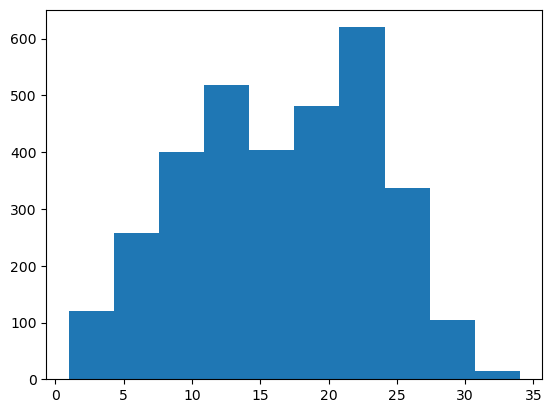

In [6]:
rv_l = [len(doc) for doc in pre_train_dataset['input_ids']]
print('Mean of the document length: {}'.format(np.mean(rv_l)))
print('Median of the document length: {}'.format(np.median(rv_l)))
print('Maximum document length: {}'.format(np.max(rv_l)))

plt.hist(rv_l)

# Full Model

In [7]:
# tokenize from full bert model
model_full = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)
tokenizer_full = AutoTokenizer.from_pretrained("bert-base-uncased")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
def tokenize_function(dataset):
    model_inputs = tokenizer_full(dataset['text'], padding="max_length", max_length=128, truncation=True)
    return model_inputs

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

In [9]:
for param in model_full.bert.parameters(): # access the weights inside BERT through the variable `model.bert`.
    param.requires_grad = False # unfreez = True

In [10]:
# define training arguments
training_args = TrainingArguments(
    output_dir="transformer_checkpoints",
    num_train_epochs=15,
    per_device_train_batch_size=32,
    logging_steps=50,
    eval_steps=len(train_dataset) // 32,  
    save_steps=len(train_dataset) // 32, 
    evaluation_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model_full,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)



In [11]:
# train...
train_result = trainer.train()
trainer.save_model()

  0%|          | 0/1530 [00:00<?, ?it/s]

{'loss': 1.3678, 'grad_norm': 1.7076489925384521, 'learning_rate': 4.8366013071895424e-05, 'epoch': 0.49}
{'loss': 1.2936, 'grad_norm': 2.500053882598877, 'learning_rate': 4.673202614379085e-05, 'epoch': 0.98}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.2730768918991089, 'eval_runtime': 8.5107, 'eval_samples_per_second': 43.945, 'eval_steps_per_second': 5.522, 'epoch': 0.99}
{'loss': 1.2774, 'grad_norm': 1.4632378816604614, 'learning_rate': 4.5098039215686275e-05, 'epoch': 1.47}
{'loss': 1.2738, 'grad_norm': 4.62844705581665, 'learning_rate': 4.3464052287581704e-05, 'epoch': 1.96}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.2610235214233398, 'eval_runtime': 8.1507, 'eval_samples_per_second': 45.886, 'eval_steps_per_second': 5.766, 'epoch': 1.98}
{'loss': 1.2555, 'grad_norm': 1.8915355205535889, 'learning_rate': 4.1830065359477126e-05, 'epoch': 2.45}
{'loss': 1.2623, 'grad_norm': 1.667352318763733, 'learning_rate': 4.0196078431372555e-05, 'epoch': 2.94}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.2498271465301514, 'eval_runtime': 8.5603, 'eval_samples_per_second': 43.69, 'eval_steps_per_second': 5.49, 'epoch': 2.97}
{'loss': 1.2683, 'grad_norm': 3.827496290206909, 'learning_rate': 3.8562091503267977e-05, 'epoch': 3.43}
{'loss': 1.2541, 'grad_norm': 1.6944833993911743, 'learning_rate': 3.6928104575163405e-05, 'epoch': 3.92}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.2431493997573853, 'eval_runtime': 10.8215, 'eval_samples_per_second': 34.561, 'eval_steps_per_second': 4.343, 'epoch': 3.96}
{'loss': 1.2621, 'grad_norm': 1.9015132188796997, 'learning_rate': 3.529411764705883e-05, 'epoch': 4.41}
{'loss': 1.2517, 'grad_norm': 3.721285104751587, 'learning_rate': 3.366013071895425e-05, 'epoch': 4.9}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.2430251836776733, 'eval_runtime': 12.0606, 'eval_samples_per_second': 31.01, 'eval_steps_per_second': 3.897, 'epoch': 4.95}
{'loss': 1.2437, 'grad_norm': 1.9429720640182495, 'learning_rate': 3.202614379084967e-05, 'epoch': 5.39}
{'loss': 1.246, 'grad_norm': 2.27754545211792, 'learning_rate': 3.0392156862745097e-05, 'epoch': 5.88}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.2346482276916504, 'eval_runtime': 5.9616, 'eval_samples_per_second': 62.735, 'eval_steps_per_second': 7.884, 'epoch': 5.94}
{'loss': 1.2531, 'grad_norm': 1.5347769260406494, 'learning_rate': 2.8758169934640522e-05, 'epoch': 6.37}
{'loss': 1.2404, 'grad_norm': 1.8089923858642578, 'learning_rate': 2.7124183006535947e-05, 'epoch': 6.86}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.2305933237075806, 'eval_runtime': 8.7344, 'eval_samples_per_second': 42.819, 'eval_steps_per_second': 5.381, 'epoch': 6.93}
{'loss': 1.2413, 'grad_norm': 2.738743543624878, 'learning_rate': 2.5490196078431373e-05, 'epoch': 7.35}
{'loss': 1.248, 'grad_norm': 1.9312057495117188, 'learning_rate': 2.38562091503268e-05, 'epoch': 7.84}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.2269959449768066, 'eval_runtime': 8.1816, 'eval_samples_per_second': 45.712, 'eval_steps_per_second': 5.745, 'epoch': 7.92}
{'loss': 1.2319, 'grad_norm': 3.386138439178467, 'learning_rate': 2.2222222222222223e-05, 'epoch': 8.33}
{'loss': 1.2412, 'grad_norm': 2.100773572921753, 'learning_rate': 2.058823529411765e-05, 'epoch': 8.82}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.2242474555969238, 'eval_runtime': 7.9923, 'eval_samples_per_second': 46.795, 'eval_steps_per_second': 5.881, 'epoch': 8.91}
{'loss': 1.2411, 'grad_norm': 1.5351327657699585, 'learning_rate': 1.895424836601307e-05, 'epoch': 9.31}
{'loss': 1.2351, 'grad_norm': 2.3119142055511475, 'learning_rate': 1.7320261437908496e-05, 'epoch': 9.8}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.221115231513977, 'eval_runtime': 7.8413, 'eval_samples_per_second': 47.696, 'eval_steps_per_second': 5.994, 'epoch': 9.9}
{'loss': 1.2301, 'grad_norm': 2.716655969619751, 'learning_rate': 1.568627450980392e-05, 'epoch': 10.29}
{'loss': 1.2525, 'grad_norm': 2.6091814041137695, 'learning_rate': 1.4052287581699347e-05, 'epoch': 10.78}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.2182294130325317, 'eval_runtime': 8.0223, 'eval_samples_per_second': 46.62, 'eval_steps_per_second': 5.859, 'epoch': 10.89}
{'loss': 1.2329, 'grad_norm': 3.1800942420959473, 'learning_rate': 1.2418300653594772e-05, 'epoch': 11.27}
{'loss': 1.2176, 'grad_norm': 2.851099967956543, 'learning_rate': 1.0784313725490197e-05, 'epoch': 11.76}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.2176216840744019, 'eval_runtime': 8.1244, 'eval_samples_per_second': 46.034, 'eval_steps_per_second': 5.785, 'epoch': 11.88}
{'loss': 1.2511, 'grad_norm': 1.68696928024292, 'learning_rate': 9.150326797385621e-06, 'epoch': 12.25}
{'loss': 1.2228, 'grad_norm': 3.7537641525268555, 'learning_rate': 7.5163398692810456e-06, 'epoch': 12.75}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.2176765203475952, 'eval_runtime': 7.872, 'eval_samples_per_second': 47.51, 'eval_steps_per_second': 5.971, 'epoch': 12.87}
{'loss': 1.2363, 'grad_norm': 1.8417423963546753, 'learning_rate': 5.882352941176471e-06, 'epoch': 13.24}
{'loss': 1.234, 'grad_norm': 2.9903056621551514, 'learning_rate': 4.2483660130718954e-06, 'epoch': 13.73}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.2169784307479858, 'eval_runtime': 8.0325, 'eval_samples_per_second': 46.561, 'eval_steps_per_second': 5.851, 'epoch': 13.86}
{'loss': 1.2318, 'grad_norm': 3.1527676582336426, 'learning_rate': 2.6143790849673204e-06, 'epoch': 14.22}
{'loss': 1.2127, 'grad_norm': 2.486504554748535, 'learning_rate': 9.80392156862745e-07, 'epoch': 14.71}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.2170640230178833, 'eval_runtime': 7.6173, 'eval_samples_per_second': 49.099, 'eval_steps_per_second': 6.17, 'epoch': 14.85}
{'train_runtime': 1325.2991, 'train_samples_per_second': 36.863, 'train_steps_per_second': 1.154, 'train_loss': 1.250240600187015, 'epoch': 15.0}


In [12]:
def predict_nn(trained_model, test_dataset):
    device = torch.device("cpu")
    trained_model.to(device)

    # switch off dropout
    trained_model.eval()
    
    # pass the required items from the dataset to the model    
    output = trained_model(attention_mask=torch.tensor(test_dataset["attention_mask"]).to('cpu'), 
                           input_ids=torch.tensor(test_dataset["input_ids"]).to('cpu'))
 
 
    pred_labs = np.argmax(output["logits"].detach().numpy(), axis=1)

    return pred_labs

In [13]:
# run the prediction function
pred_labs_frozen = predict_nn(model_full, test_dataset)

gold_labs = test_dataset["label"]

In [14]:
f1 = f1_score(np.array(gold_labs).flatten(), pred_labs_frozen.flatten(), average='macro')
print(f'FROZEN MODEL F1 = {f1}')

FROZEN MODEL F1 = 0.14394155268490375


In [15]:
acc = accuracy_score(np.array(gold_labs).flatten(), pred_labs_frozen.flatten())
print(f'FROZEN MODEL ACCURACY = {acc}')

FROZEN MODEL ACCURACY = 0.39408866995073893


In [16]:
print(classification_report(np.array(gold_labs).flatten(), pred_labs_frozen.flatten()))

              precision    recall  f1-score   support

           0       0.39      1.00      0.57       558
           1       0.00      0.00      0.00       358
           2       0.00      0.00      0.00       123
           3       1.00      0.01      0.01       382

    accuracy                           0.39      1421
   macro avg       0.35      0.25      0.14      1421
weighted avg       0.42      0.39      0.22      1421



/Users/blackrose/anaconda3/envs/text_analytics/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blackrose/anaconda3/envs/text_analytics/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blackrose/anaconda3/envs/text_analytics/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

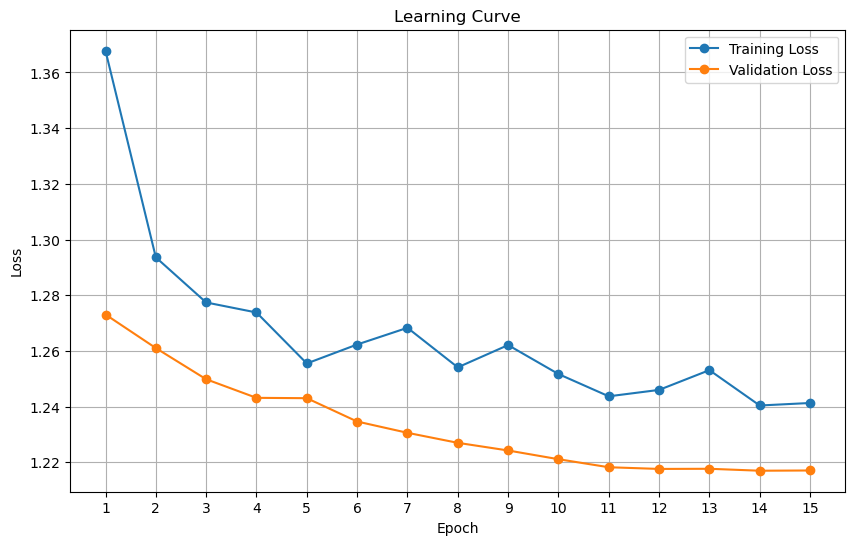

In [17]:
train_losses = [entry['loss'] for entry in trainer.state.log_history if 'loss' in entry and 'eval_loss' not in entry]
eval_losses = [entry['eval_loss'] for entry in trainer.state.log_history if 'eval_loss' in entry]


plt.figure(figsize=(10, 6))
epochs = range(1, training_args.num_train_epochs + 1)
if len(train_losses) >= training_args.num_train_epochs:
    plt.plot(epochs, train_losses[:training_args.num_train_epochs], label='Training Loss', marker='o')
if len(eval_losses) >= training_args.num_train_epochs:
    plt.plot(epochs, eval_losses[:training_args.num_train_epochs], label='Validation Loss', marker='o')

plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(epochs)
plt.show()

# TinyBERT - Tokenizers

In [18]:
model = AutoModelForSequenceClassification.from_pretrained("huawei-noah/TinyBERT_General_4L_312D", num_labels=4)
print(model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, e

In [19]:
# tokenize...
tokenizer = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")

def tokenize_function(dataset):
    model_inputs = tokenizer(dataset['text'], padding="max_length", max_length=128, truncation=True)
    return model_inputs

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

In [20]:
train_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3257
})

## Model without tuning with FREEZE

In [21]:
train_dataset['label']

[2,
 0,
 1,
 0,
 3,
 0,
 3,
 1,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 3,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 3,
 3,
 1,
 2,
 1,
 3,
 0,
 0,
 0,
 0,
 0,
 3,
 3,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 2,
 0,
 0,
 1,
 3,
 0,
 1,
 0,
 3,
 0,
 3,
 0,
 0,
 1,
 0,
 0,
 3,
 0,
 1,
 0,
 3,
 1,
 0,
 3,
 3,
 2,
 3,
 3,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 3,
 3,
 1,
 0,
 0,
 1,
 0,
 2,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 0,
 3,
 3,
 1,
 3,
 3,
 1,
 2,
 2,
 3,
 0,
 3,
 2,
 0,
 1,
 0,
 0,
 1,
 3,
 0,
 0,
 1,
 2,
 3,
 1,
 3,
 0,
 3,
 0,
 1,
 3,
 1,
 2,
 3,
 3,
 0,
 3,
 3,
 0,
 2,
 3,
 0,
 3,
 1,
 1,
 1,
 2,
 0,
 0,
 0,
 1,
 3,
 0,
 0,
 3,
 3,
 3,
 1,
 0,
 0,
 0,
 0,
 1,
 3,
 1,
 3,
 0,
 0,
 0,
 1,
 3,
 2,
 1,
 0,
 1,
 0,
 3,
 0,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 0,
 0,
 2,
 1,
 0,
 0,
 2,
 1,
 3,
 1,
 0,
 3,
 0,
 1,
 3,
 3,
 1,
 3,
 0,
 3,
 1,
 3,
 1,
 2,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 2,
 0,
 2,
 0,
 1,
 3,
 1,
 3,
 2,
 1,
 3,
 0,
 3,
 0,
 3,


In [22]:
for param in model.bert.parameters(): # access the weights inside BERT through the variable `model.bert`.
    param.requires_grad = False # unfreez = True

In [23]:
steps_per_epoch = len(train_dataset) // 32

training_args = TrainingArguments(
    output_dir="transformer_checkpoints",
    num_train_epochs=15,
    per_device_train_batch_size=32,
    logging_steps=50,
    eval_steps=steps_per_epoch,  # evaluation each epoch
    save_steps=steps_per_epoch,  # saving each epoch
    evaluation_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [24]:
# train...
train_result = trainer.train()
trainer.save_model()

  0%|          | 0/1530 [00:00<?, ?it/s]

{'loss': 1.3818, 'grad_norm': 0.24177515506744385, 'learning_rate': 4.8366013071895424e-05, 'epoch': 0.49}
{'loss': 1.3759, 'grad_norm': 0.16226467490196228, 'learning_rate': 4.673202614379085e-05, 'epoch': 0.98}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.3717447519302368, 'eval_runtime': 0.8734, 'eval_samples_per_second': 428.199, 'eval_steps_per_second': 53.811, 'epoch': 0.99}
{'loss': 1.3706, 'grad_norm': 0.25864294171333313, 'learning_rate': 4.5098039215686275e-05, 'epoch': 1.47}
{'loss': 1.3642, 'grad_norm': 0.5606467723846436, 'learning_rate': 4.3464052287581704e-05, 'epoch': 1.96}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.3607711791992188, 'eval_runtime': 0.8843, 'eval_samples_per_second': 422.946, 'eval_steps_per_second': 53.151, 'epoch': 1.98}
{'loss': 1.3592, 'grad_norm': 0.34672775864601135, 'learning_rate': 4.1830065359477126e-05, 'epoch': 2.45}
{'loss': 1.3543, 'grad_norm': 0.17764976620674133, 'learning_rate': 4.0196078431372555e-05, 'epoch': 2.94}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.3510469198226929, 'eval_runtime': 0.8995, 'eval_samples_per_second': 415.783, 'eval_steps_per_second': 52.251, 'epoch': 2.97}
{'loss': 1.3523, 'grad_norm': 0.4079536497592926, 'learning_rate': 3.8562091503267977e-05, 'epoch': 3.43}
{'loss': 1.3454, 'grad_norm': 0.1730949431657791, 'learning_rate': 3.6928104575163405e-05, 'epoch': 3.92}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.3428692817687988, 'eval_runtime': 0.8947, 'eval_samples_per_second': 418.025, 'eval_steps_per_second': 52.533, 'epoch': 3.96}
{'loss': 1.3444, 'grad_norm': 0.33625683188438416, 'learning_rate': 3.529411764705883e-05, 'epoch': 4.41}
{'loss': 1.3398, 'grad_norm': 0.43925052881240845, 'learning_rate': 3.366013071895425e-05, 'epoch': 4.9}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.3360177278518677, 'eval_runtime': 0.9016, 'eval_samples_per_second': 414.814, 'eval_steps_per_second': 52.129, 'epoch': 4.95}
{'loss': 1.3361, 'grad_norm': 0.24475987255573273, 'learning_rate': 3.202614379084967e-05, 'epoch': 5.39}
{'loss': 1.3331, 'grad_norm': 0.14596675336360931, 'learning_rate': 3.0392156862745097e-05, 'epoch': 5.88}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.3298503160476685, 'eval_runtime': 0.8843, 'eval_samples_per_second': 422.929, 'eval_steps_per_second': 53.149, 'epoch': 5.94}
{'loss': 1.3333, 'grad_norm': 0.17411036789417267, 'learning_rate': 2.8758169934640522e-05, 'epoch': 6.37}
{'loss': 1.3269, 'grad_norm': 0.15692536532878876, 'learning_rate': 2.7124183006535947e-05, 'epoch': 6.86}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.3247758150100708, 'eval_runtime': 0.8845, 'eval_samples_per_second': 422.821, 'eval_steps_per_second': 53.135, 'epoch': 6.93}
{'loss': 1.3254, 'grad_norm': 0.11518675088882446, 'learning_rate': 2.5490196078431373e-05, 'epoch': 7.35}
{'loss': 1.3257, 'grad_norm': 0.2669573128223419, 'learning_rate': 2.38562091503268e-05, 'epoch': 7.84}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.3204445838928223, 'eval_runtime': 0.9049, 'eval_samples_per_second': 413.323, 'eval_steps_per_second': 51.942, 'epoch': 7.92}
{'loss': 1.3202, 'grad_norm': 0.2748112976551056, 'learning_rate': 2.2222222222222223e-05, 'epoch': 8.33}
{'loss': 1.3222, 'grad_norm': 0.2315017431974411, 'learning_rate': 2.058823529411765e-05, 'epoch': 8.82}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.316735863685608, 'eval_runtime': 0.9063, 'eval_samples_per_second': 412.646, 'eval_steps_per_second': 51.857, 'epoch': 8.91}
{'loss': 1.3183, 'grad_norm': 0.24358564615249634, 'learning_rate': 1.895424836601307e-05, 'epoch': 9.31}
{'loss': 1.316, 'grad_norm': 0.0989002212882042, 'learning_rate': 1.7320261437908496e-05, 'epoch': 9.8}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.3137354850769043, 'eval_runtime': 0.8876, 'eval_samples_per_second': 421.342, 'eval_steps_per_second': 52.949, 'epoch': 9.9}
{'loss': 1.3152, 'grad_norm': 0.21031151711940765, 'learning_rate': 1.568627450980392e-05, 'epoch': 10.29}
{'loss': 1.3212, 'grad_norm': 0.33155229687690735, 'learning_rate': 1.4052287581699347e-05, 'epoch': 10.78}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.3113734722137451, 'eval_runtime': 0.8967, 'eval_samples_per_second': 417.094, 'eval_steps_per_second': 52.416, 'epoch': 10.89}
{'loss': 1.3117, 'grad_norm': 0.30713382363319397, 'learning_rate': 1.2418300653594772e-05, 'epoch': 11.27}
{'loss': 1.3099, 'grad_norm': 0.2021859884262085, 'learning_rate': 1.0784313725490197e-05, 'epoch': 11.76}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.3094614744186401, 'eval_runtime': 0.891, 'eval_samples_per_second': 419.768, 'eval_steps_per_second': 52.752, 'epoch': 11.88}
{'loss': 1.3167, 'grad_norm': 0.20988816022872925, 'learning_rate': 9.150326797385621e-06, 'epoch': 12.25}
{'loss': 1.3089, 'grad_norm': 0.28040164709091187, 'learning_rate': 7.5163398692810456e-06, 'epoch': 12.75}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.308170199394226, 'eval_runtime': 0.8958, 'eval_samples_per_second': 417.514, 'eval_steps_per_second': 52.468, 'epoch': 12.87}
{'loss': 1.315, 'grad_norm': 0.25098785758018494, 'learning_rate': 5.882352941176471e-06, 'epoch': 13.24}
{'loss': 1.3113, 'grad_norm': 0.07769384235143661, 'learning_rate': 4.2483660130718954e-06, 'epoch': 13.73}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.3073424100875854, 'eval_runtime': 0.8897, 'eval_samples_per_second': 420.386, 'eval_steps_per_second': 52.829, 'epoch': 13.86}
{'loss': 1.3114, 'grad_norm': 0.37473535537719727, 'learning_rate': 2.6143790849673204e-06, 'epoch': 14.22}
{'loss': 1.3034, 'grad_norm': 0.25427448749542236, 'learning_rate': 9.80392156862745e-07, 'epoch': 14.71}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.3070199489593506, 'eval_runtime': 0.8929, 'eval_samples_per_second': 418.84, 'eval_steps_per_second': 52.635, 'epoch': 14.85}
{'train_runtime': 153.3937, 'train_samples_per_second': 318.494, 'train_steps_per_second': 9.974, 'train_loss': 1.3319779838611876, 'epoch': 15.0}


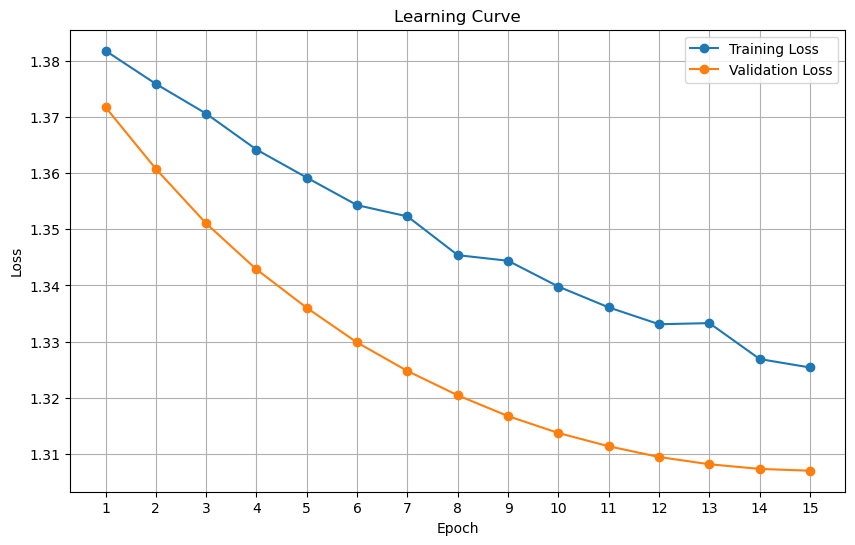

In [25]:
train_losses = [entry['loss'] for entry in trainer.state.log_history if 'loss' in entry and 'eval_loss' not in entry]
eval_losses = [entry['eval_loss'] for entry in trainer.state.log_history if 'eval_loss' in entry]



plt.figure(figsize=(10, 6))
epochs = range(1, training_args.num_train_epochs + 1)
if len(train_losses) >= training_args.num_train_epochs:
    plt.plot(epochs, train_losses[:training_args.num_train_epochs], label='Training Loss', marker='o')
if len(eval_losses) >= training_args.num_train_epochs:
    plt.plot(epochs, eval_losses[:training_args.num_train_epochs], label='Validation Loss', marker='o')

plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(epochs)
plt.show()

In [26]:
def predict_nn(trained_model, test_dataset):
    device = torch.device("cpu")
    trained_model.to(device)

    # switch off dropout
    trained_model.eval()
    
    # pass the required items from the dataset to the model    
    output = trained_model(attention_mask=torch.tensor(test_dataset["attention_mask"]).to('cpu'), 
                           input_ids=torch.tensor(test_dataset["input_ids"]).to('cpu'))


    pred_labs = np.argmax(output["logits"].detach().numpy(), axis=1)

    return pred_labs

In [27]:
# run the prediction function
pred_labs_frozen = predict_nn(model, test_dataset)

gold_labs = test_dataset["label"]

In [28]:
f1 = f1_score(np.array(gold_labs).flatten(), pred_labs_frozen.flatten(), average='macro')
print(f'FROZEN MODEL F1 = {f1}')

FROZEN MODEL F1 = 0.14098029307731177


In [29]:
acc = accuracy_score(np.array(gold_labs).flatten(), pred_labs_frozen.flatten())
print(f'FROZEN MODEL ACCURACY = {acc}')

FROZEN MODEL ACCURACY = 0.39268121041520054


In [30]:
full_dataset = concatenate_datasets([train_dataset, val_dataset])

full_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3631
})

## Model without tuning with UNFREEZE

In [31]:
for param in model.bert.parameters(): # access the weights inside BERT through the variable `model.bert`.
    param.requires_grad = True # unfreez = True

In [32]:
steps_per_epoch = len(train_dataset) // 32

training_args = TrainingArguments(
    output_dir="transformer_checkpoints",
    num_train_epochs=15,
    per_device_train_batch_size=32,
    logging_steps=50,
    eval_steps=steps_per_epoch,  
    save_steps=steps_per_epoch,  
    evaluation_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [33]:
# train...
train_result = trainer.train()
trainer.save_model()


  0%|          | 0/1530 [00:00<?, ?it/s]

{'loss': 1.1312, 'grad_norm': 5.499999523162842, 'learning_rate': 4.8366013071895424e-05, 'epoch': 0.49}
{'loss': 0.9392, 'grad_norm': 8.835516929626465, 'learning_rate': 4.673202614379085e-05, 'epoch': 0.98}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.8552692532539368, 'eval_runtime': 0.8672, 'eval_samples_per_second': 431.264, 'eval_steps_per_second': 54.196, 'epoch': 0.99}
{'loss': 0.7696, 'grad_norm': 16.239580154418945, 'learning_rate': 4.5098039215686275e-05, 'epoch': 1.47}
{'loss': 0.7475, 'grad_norm': 5.390665054321289, 'learning_rate': 4.3464052287581704e-05, 'epoch': 1.96}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.8016021847724915, 'eval_runtime': 0.8655, 'eval_samples_per_second': 432.102, 'eval_steps_per_second': 54.302, 'epoch': 1.98}
{'loss': 0.6314, 'grad_norm': 12.511877059936523, 'learning_rate': 4.1830065359477126e-05, 'epoch': 2.45}
{'loss': 0.5485, 'grad_norm': 7.382737636566162, 'learning_rate': 4.0196078431372555e-05, 'epoch': 2.94}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.7508272528648376, 'eval_runtime': 0.8683, 'eval_samples_per_second': 430.706, 'eval_steps_per_second': 54.126, 'epoch': 2.97}
{'loss': 0.5062, 'grad_norm': 7.668274402618408, 'learning_rate': 3.8562091503267977e-05, 'epoch': 3.43}
{'loss': 0.4597, 'grad_norm': 17.581785202026367, 'learning_rate': 3.6928104575163405e-05, 'epoch': 3.92}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.7656427025794983, 'eval_runtime': 0.8782, 'eval_samples_per_second': 425.863, 'eval_steps_per_second': 53.518, 'epoch': 3.96}
{'loss': 0.4081, 'grad_norm': 15.551036834716797, 'learning_rate': 3.529411764705883e-05, 'epoch': 4.41}
{'loss': 0.3931, 'grad_norm': 16.948036193847656, 'learning_rate': 3.366013071895425e-05, 'epoch': 4.9}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.7687695622444153, 'eval_runtime': 0.868, 'eval_samples_per_second': 430.89, 'eval_steps_per_second': 54.149, 'epoch': 4.95}
{'loss': 0.3267, 'grad_norm': 8.250143051147461, 'learning_rate': 3.202614379084967e-05, 'epoch': 5.39}
{'loss': 0.3122, 'grad_norm': 14.653374671936035, 'learning_rate': 3.0392156862745097e-05, 'epoch': 5.88}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.7722097039222717, 'eval_runtime': 0.8753, 'eval_samples_per_second': 427.28, 'eval_steps_per_second': 53.696, 'epoch': 5.94}
{'loss': 0.2673, 'grad_norm': 41.846519470214844, 'learning_rate': 2.8758169934640522e-05, 'epoch': 6.37}
{'loss': 0.2614, 'grad_norm': 24.803611755371094, 'learning_rate': 2.7124183006535947e-05, 'epoch': 6.86}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.8213162422180176, 'eval_runtime': 0.8759, 'eval_samples_per_second': 426.991, 'eval_steps_per_second': 53.659, 'epoch': 6.93}
{'loss': 0.2483, 'grad_norm': 13.764420509338379, 'learning_rate': 2.5490196078431373e-05, 'epoch': 7.35}
{'loss': 0.1892, 'grad_norm': 2.3930442333221436, 'learning_rate': 2.38562091503268e-05, 'epoch': 7.84}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.8691422343254089, 'eval_runtime': 0.8736, 'eval_samples_per_second': 428.118, 'eval_steps_per_second': 53.801, 'epoch': 7.92}
{'loss': 0.1858, 'grad_norm': 1.9490281343460083, 'learning_rate': 2.2222222222222223e-05, 'epoch': 8.33}
{'loss': 0.181, 'grad_norm': 11.407302856445312, 'learning_rate': 2.058823529411765e-05, 'epoch': 8.82}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.8865276575088501, 'eval_runtime': 0.8645, 'eval_samples_per_second': 432.608, 'eval_steps_per_second': 54.365, 'epoch': 8.91}
{'loss': 0.1556, 'grad_norm': 7.252923011779785, 'learning_rate': 1.895424836601307e-05, 'epoch': 9.31}
{'loss': 0.1354, 'grad_norm': 11.047446250915527, 'learning_rate': 1.7320261437908496e-05, 'epoch': 9.8}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.8993342518806458, 'eval_runtime': 0.8876, 'eval_samples_per_second': 421.362, 'eval_steps_per_second': 52.952, 'epoch': 9.9}
{'loss': 0.1305, 'grad_norm': 8.952240943908691, 'learning_rate': 1.568627450980392e-05, 'epoch': 10.29}
{'loss': 0.126, 'grad_norm': 2.9202826023101807, 'learning_rate': 1.4052287581699347e-05, 'epoch': 10.78}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.9325895309448242, 'eval_runtime': 0.867, 'eval_samples_per_second': 431.375, 'eval_steps_per_second': 54.21, 'epoch': 10.89}
{'loss': 0.1214, 'grad_norm': 27.2493953704834, 'learning_rate': 1.2418300653594772e-05, 'epoch': 11.27}
{'loss': 0.0857, 'grad_norm': 13.017618179321289, 'learning_rate': 1.0784313725490197e-05, 'epoch': 11.76}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.0115083456039429, 'eval_runtime': 0.8678, 'eval_samples_per_second': 430.972, 'eval_steps_per_second': 54.16, 'epoch': 11.88}
{'loss': 0.1023, 'grad_norm': 2.7763054370880127, 'learning_rate': 9.150326797385621e-06, 'epoch': 12.25}
{'loss': 0.0811, 'grad_norm': 4.856326580047607, 'learning_rate': 7.5163398692810456e-06, 'epoch': 12.75}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.9935446381568909, 'eval_runtime': 0.8722, 'eval_samples_per_second': 428.791, 'eval_steps_per_second': 53.885, 'epoch': 12.87}
{'loss': 0.0826, 'grad_norm': 10.301961898803711, 'learning_rate': 5.882352941176471e-06, 'epoch': 13.24}
{'loss': 0.0815, 'grad_norm': 1.587992787361145, 'learning_rate': 4.2483660130718954e-06, 'epoch': 13.73}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.0035134553909302, 'eval_runtime': 0.8658, 'eval_samples_per_second': 431.965, 'eval_steps_per_second': 54.284, 'epoch': 13.86}
{'loss': 0.0714, 'grad_norm': 2.517117738723755, 'learning_rate': 2.6143790849673204e-06, 'epoch': 14.22}
{'loss': 0.0743, 'grad_norm': 10.735454559326172, 'learning_rate': 9.80392156862745e-07, 'epoch': 14.71}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.998744785785675, 'eval_runtime': 0.9318, 'eval_samples_per_second': 401.395, 'eval_steps_per_second': 50.443, 'epoch': 14.85}
{'train_runtime': 398.3116, 'train_samples_per_second': 122.655, 'train_steps_per_second': 3.841, 'train_loss': 0.32001137577630334, 'epoch': 15.0}


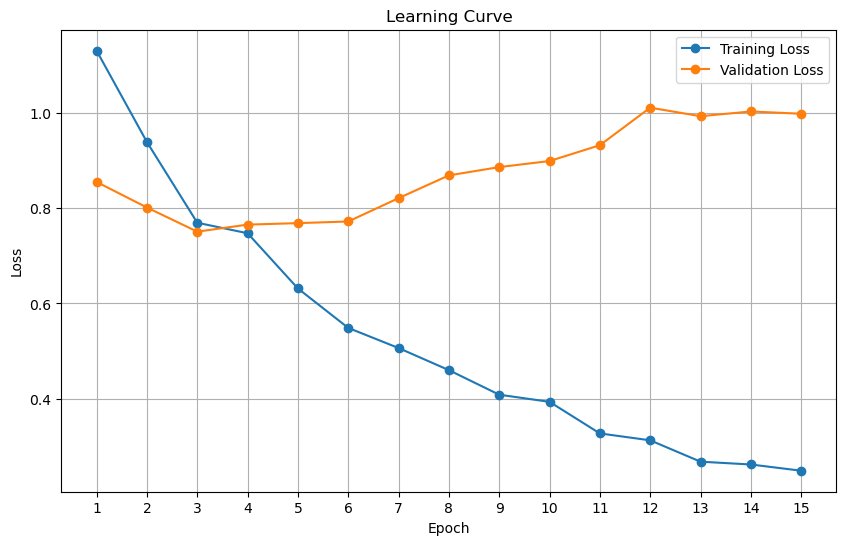

In [34]:
train_losses = [entry['loss'] for entry in trainer.state.log_history if 'loss' in entry and 'eval_loss' not in entry]
eval_losses = [entry['eval_loss'] for entry in trainer.state.log_history if 'eval_loss' in entry]



plt.figure(figsize=(10, 6))
epochs = range(1, training_args.num_train_epochs + 1)
if len(train_losses) >= training_args.num_train_epochs:
    plt.plot(epochs, train_losses[:training_args.num_train_epochs], label='Training Loss', marker='o')
if len(eval_losses) >= training_args.num_train_epochs:
    plt.plot(epochs, eval_losses[:training_args.num_train_epochs], label='Validation Loss', marker='o')

plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(epochs)
plt.show()

In [35]:
# run the prediction function
pred_labs_frozen = predict_nn(model, test_dataset)

gold_labs = test_dataset["label"]

In [36]:
f1 = f1_score(np.array(gold_labs).flatten(), pred_labs_frozen.flatten(), average='macro')
print(f'UNFROZEN MODEL F1 = {f1}')

UNFROZEN MODEL F1 = 0.6870941353058295


In [37]:
acc = accuracy_score(np.array(gold_labs).flatten(), pred_labs_frozen.flatten())
print(f'UNFROZEN MODEL ACCURACY = {acc}')

UNFROZEN MODEL ACCURACY = 0.7719915552427867


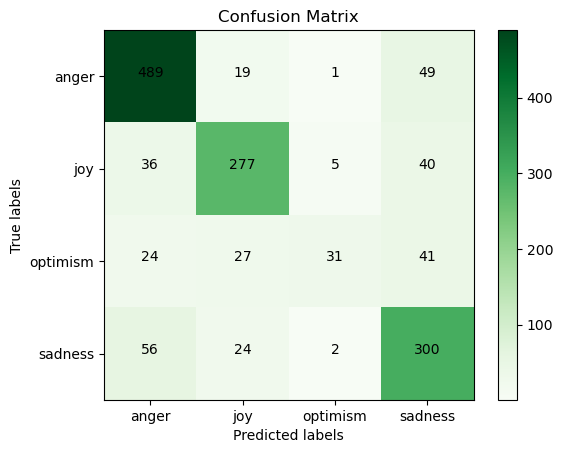

In [38]:
conf_matrix = confusion_matrix(np.array(gold_labs).flatten(), pred_labs_frozen.flatten())

# map emotion labels
emotion_labels = {0: 'anger', 1: 'joy', 2: 'optimism', 3: 'sadness'}

plt.figure()
plt.imshow(conf_matrix, cmap='Greens', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = range(len(conf_matrix))
plt.xticks(tick_marks, [emotion_labels[i] for i in range(len(conf_matrix))])
plt.yticks(tick_marks, [emotion_labels[i] for i in range(len(conf_matrix))])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# add counts in the matrix
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j, i, str(conf_matrix[i][j]), horizontalalignment='center', color='black')



## Tuning

In [39]:
model = AutoModelForSequenceClassification.from_pretrained("huawei-noah/TinyBERT_General_4L_312D", num_labels=4)
print(model)

# tokenize...
tokenizer = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")

def tokenize_function(dataset):
    model_inputs = tokenizer(dataset['text'], padding="max_length", max_length=128, truncation=True)
    return model_inputs

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, e

In [40]:
full_dataset = concatenate_datasets([train_dataset, val_dataset])

full_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3631
})

In [41]:
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.eval_loss = []

    def on_train_begin(self, args, state, control, **kwargs):
        self.train_loss = []
        self.eval_loss = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.train_loss.append((state.global_step, logs['loss']))
        if 'eval_loss' in logs:
            self.eval_loss.append((state.global_step, logs['eval_loss']))

# tuning
def objective(trial):
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    learning_rate = trial.suggest_loguniform("learning_rate", 2e-5, 5e-5)

    model = AutoModelForSequenceClassification.from_pretrained("huawei-noah/TinyBERT_General_4L_312D", num_labels=4)

    kfold = KFold(n_splits=3, shuffle=True, random_state=10)
    val_losses = []

    for train_idx, val_idx in kfold.split(full_dataset):
        train_subset = full_dataset.select(train_idx)
        val_subset = full_dataset.select(val_idx)
        steps_per_epoch = len(train_dataset) // batch_size
        
        training_args = TrainingArguments(
            output_dir="./transformer_checkpoints",
            num_train_epochs=15,
            per_device_train_batch_size=batch_size,
            learning_rate=learning_rate,
            logging_steps=50,
            eval_steps=steps_per_epoch,  
            save_steps=steps_per_epoch,  
            evaluation_strategy="steps",
            save_strategy="steps",
            load_best_model_at_end=True,
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_subset,
            eval_dataset=val_subset,
            callbacks=[metrics_callback]
        )

        trainer.train()
        eval_metrics = trainer.evaluate()
        val_losses.append(eval_metrics["eval_loss"])

    return np.mean(val_losses)
 
metrics_callback = MetricsCallback()

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=10))
study.optimize(objective, n_trials=5)


[I 2024-05-20 00:20:59,877] A new study created in memory with name: no-name-95ace6dc-97de-4347-958a-6fde3bfb853b
/var/folders/j7/k1zn5v217flb70ktdfw_fzdc0000gn/T/ipykernel_1331/1863795062.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 2e-5, 5e-5)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/2280 [00:00<?, ?it/s]

{'loss': 1.2822, 'grad_norm': 2.8903205394744873, 'learning_rate': 3.884892763077287e-05, 'epoch': 0.33}
{'loss': 1.0835, 'grad_norm': 7.938998699188232, 'learning_rate': 3.797787544174209e-05, 'epoch': 0.66}
{'loss': 0.9759, 'grad_norm': 8.144035339355469, 'learning_rate': 3.710682325271131e-05, 'epoch': 0.99}
{'loss': 0.8231, 'grad_norm': 4.3034234046936035, 'learning_rate': 3.623577106368052e-05, 'epoch': 1.32}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.8315130472183228, 'eval_runtime': 2.5997, 'eval_samples_per_second': 465.825, 'eval_steps_per_second': 58.469, 'epoch': 1.34}
{'loss': 0.8061, 'grad_norm': 6.117469787597656, 'learning_rate': 3.5364718874649745e-05, 'epoch': 1.64}
{'loss': 0.744, 'grad_norm': 13.72474193572998, 'learning_rate': 3.449366668561896e-05, 'epoch': 1.97}
{'loss': 0.6902, 'grad_norm': 19.450000762939453, 'learning_rate': 3.362261449658818e-05, 'epoch': 2.3}
{'loss': 0.6646, 'grad_norm': 8.810738563537598, 'learning_rate': 3.2751562307557395e-05, 'epoch': 2.63}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7408725619316101, 'eval_runtime': 2.5473, 'eval_samples_per_second': 475.411, 'eval_steps_per_second': 59.672, 'epoch': 2.67}
{'loss': 0.6251, 'grad_norm': 6.8421783447265625, 'learning_rate': 3.1880510118526616e-05, 'epoch': 2.96}
{'loss': 0.5172, 'grad_norm': 17.527070999145508, 'learning_rate': 3.100945792949583e-05, 'epoch': 3.29}
{'loss': 0.5258, 'grad_norm': 14.179718017578125, 'learning_rate': 3.0138405740465052e-05, 'epoch': 3.62}
{'loss': 0.5283, 'grad_norm': 36.73884582519531, 'learning_rate': 2.926735355143427e-05, 'epoch': 3.95}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.761424720287323, 'eval_runtime': 2.5335, 'eval_samples_per_second': 478.002, 'eval_steps_per_second': 59.997, 'epoch': 4.01}
{'loss': 0.4245, 'grad_norm': 16.019535064697266, 'learning_rate': 2.8396301362403488e-05, 'epoch': 4.28}
{'loss': 0.4214, 'grad_norm': 23.291961669921875, 'learning_rate': 2.752524917337271e-05, 'epoch': 4.61}
{'loss': 0.4322, 'grad_norm': 18.980701446533203, 'learning_rate': 2.6654196984341923e-05, 'epoch': 4.93}
{'loss': 0.3757, 'grad_norm': 10.918574333190918, 'learning_rate': 2.5783144795311144e-05, 'epoch': 5.26}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7116893529891968, 'eval_runtime': 2.6163, 'eval_samples_per_second': 462.861, 'eval_steps_per_second': 58.096, 'epoch': 5.34}
{'loss': 0.3422, 'grad_norm': 13.10014533996582, 'learning_rate': 2.491209260628036e-05, 'epoch': 5.59}
{'loss': 0.2837, 'grad_norm': 34.83425521850586, 'learning_rate': 2.404104041724958e-05, 'epoch': 5.92}
{'loss': 0.3174, 'grad_norm': 12.039911270141602, 'learning_rate': 2.3169988228218798e-05, 'epoch': 6.25}
{'loss': 0.2657, 'grad_norm': 5.469587802886963, 'learning_rate': 2.2298936039188013e-05, 'epoch': 6.58}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7514196038246155, 'eval_runtime': 2.863, 'eval_samples_per_second': 422.987, 'eval_steps_per_second': 53.092, 'epoch': 6.68}
{'loss': 0.284, 'grad_norm': 20.326444625854492, 'learning_rate': 2.1427883850157234e-05, 'epoch': 6.91}
{'loss': 0.2374, 'grad_norm': 4.326676368713379, 'learning_rate': 2.0556831661126455e-05, 'epoch': 7.24}
{'loss': 0.2311, 'grad_norm': 14.121739387512207, 'learning_rate': 1.968577947209567e-05, 'epoch': 7.57}
{'loss': 0.2358, 'grad_norm': 2.3555147647857666, 'learning_rate': 1.8814727283064887e-05, 'epoch': 7.89}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.8197017908096313, 'eval_runtime': 3.3597, 'eval_samples_per_second': 360.452, 'eval_steps_per_second': 45.243, 'epoch': 8.01}
{'loss': 0.1988, 'grad_norm': 3.1114089488983154, 'learning_rate': 1.7943675094034105e-05, 'epoch': 8.22}
{'loss': 0.185, 'grad_norm': 4.583314418792725, 'learning_rate': 1.7072622905003323e-05, 'epoch': 8.55}
{'loss': 0.1601, 'grad_norm': 9.20224666595459, 'learning_rate': 1.620157071597254e-05, 'epoch': 8.88}
{'loss': 0.2064, 'grad_norm': 5.814766883850098, 'learning_rate': 1.533051852694176e-05, 'epoch': 9.21}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.8799450993537903, 'eval_runtime': 3.268, 'eval_samples_per_second': 370.568, 'eval_steps_per_second': 46.512, 'epoch': 9.35}
{'loss': 0.1416, 'grad_norm': 11.912195205688477, 'learning_rate': 1.445946633791098e-05, 'epoch': 9.54}
{'loss': 0.1591, 'grad_norm': 26.575088500976562, 'learning_rate': 1.3588414148880196e-05, 'epoch': 9.87}
{'loss': 0.1504, 'grad_norm': 36.35053253173828, 'learning_rate': 1.2717361959849414e-05, 'epoch': 10.2}
{'loss': 0.123, 'grad_norm': 2.2425084114074707, 'learning_rate': 1.1846309770818632e-05, 'epoch': 10.53}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.9288291931152344, 'eval_runtime': 3.7943, 'eval_samples_per_second': 319.159, 'eval_steps_per_second': 40.06, 'epoch': 10.68}
{'loss': 0.1393, 'grad_norm': 1.9217923879623413, 'learning_rate': 1.0975257581787852e-05, 'epoch': 10.86}
{'loss': 0.1219, 'grad_norm': 13.002474784851074, 'learning_rate': 1.010420539275707e-05, 'epoch': 11.18}
{'loss': 0.127, 'grad_norm': 13.552633285522461, 'learning_rate': 9.233153203726287e-06, 'epoch': 11.51}
{'loss': 0.1037, 'grad_norm': 28.67531394958496, 'learning_rate': 8.362101014695505e-06, 'epoch': 11.84}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.0157994031906128, 'eval_runtime': 3.087, 'eval_samples_per_second': 392.285, 'eval_steps_per_second': 49.238, 'epoch': 12.02}
{'loss': 0.1102, 'grad_norm': 0.7373706102371216, 'learning_rate': 7.491048825664724e-06, 'epoch': 12.17}
{'loss': 0.0811, 'grad_norm': 18.81411361694336, 'learning_rate': 6.619996636633942e-06, 'epoch': 12.5}
{'loss': 0.1096, 'grad_norm': 40.735355377197266, 'learning_rate': 5.74894444760316e-06, 'epoch': 12.83}
{'loss': 0.06, 'grad_norm': 1.6166126728057861, 'learning_rate': 4.877892258572378e-06, 'epoch': 13.16}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.0402501821517944, 'eval_runtime': 3.2753, 'eval_samples_per_second': 369.742, 'eval_steps_per_second': 46.409, 'epoch': 13.36}
{'loss': 0.1084, 'grad_norm': 22.367170333862305, 'learning_rate': 4.006840069541596e-06, 'epoch': 13.49}
{'loss': 0.0669, 'grad_norm': 6.755720615386963, 'learning_rate': 3.1357878805108144e-06, 'epoch': 13.82}
{'loss': 0.056, 'grad_norm': 0.48045778274536133, 'learning_rate': 2.2647356914800327e-06, 'epoch': 14.14}
{'loss': 0.1162, 'grad_norm': 1.9493005275726318, 'learning_rate': 1.3936835024492508e-06, 'epoch': 14.47}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.0434273481369019, 'eval_runtime': 3.2333, 'eval_samples_per_second': 374.535, 'eval_steps_per_second': 47.01, 'epoch': 14.69}
{'loss': 0.0557, 'grad_norm': 5.374155044555664, 'learning_rate': 5.226313134184691e-07, 'epoch': 14.8}
{'train_runtime': 369.4425, 'train_samples_per_second': 98.256, 'train_steps_per_second': 6.171, 'train_loss': 0.34518965984645644, 'epoch': 15.0}


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

{'loss': 0.5539, 'grad_norm': 16.24456024169922, 'learning_rate': 3.884892763077287e-05, 'epoch': 0.33}
{'loss': 0.5568, 'grad_norm': 11.118678092956543, 'learning_rate': 3.797787544174209e-05, 'epoch': 0.66}
{'loss': 0.565, 'grad_norm': 21.671167373657227, 'learning_rate': 3.710682325271131e-05, 'epoch': 0.99}
{'loss': 0.4479, 'grad_norm': 16.143102645874023, 'learning_rate': 3.623577106368052e-05, 'epoch': 1.32}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.33531638979911804, 'eval_runtime': 3.2014, 'eval_samples_per_second': 377.963, 'eval_steps_per_second': 47.48, 'epoch': 1.34}
{'loss': 0.4462, 'grad_norm': 10.624300003051758, 'learning_rate': 3.5364718874649745e-05, 'epoch': 1.64}
{'loss': 0.439, 'grad_norm': 15.858007431030273, 'learning_rate': 3.449366668561896e-05, 'epoch': 1.97}
{'loss': 0.3146, 'grad_norm': 5.181992530822754, 'learning_rate': 3.362261449658818e-05, 'epoch': 2.3}
{'loss': 0.3354, 'grad_norm': 22.322429656982422, 'learning_rate': 3.2751562307557395e-05, 'epoch': 2.63}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.3081725537776947, 'eval_runtime': 2.9733, 'eval_samples_per_second': 406.952, 'eval_steps_per_second': 51.121, 'epoch': 2.67}
{'loss': 0.3042, 'grad_norm': 23.54987335205078, 'learning_rate': 3.1880510118526616e-05, 'epoch': 2.96}
{'loss': 0.2232, 'grad_norm': 24.73387336730957, 'learning_rate': 3.100945792949583e-05, 'epoch': 3.29}
{'loss': 0.2489, 'grad_norm': 15.973774909973145, 'learning_rate': 3.0138405740465052e-05, 'epoch': 3.62}
{'loss': 0.3043, 'grad_norm': 25.84368324279785, 'learning_rate': 2.926735355143427e-05, 'epoch': 3.95}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.3360562026500702, 'eval_runtime': 3.0899, 'eval_samples_per_second': 391.604, 'eval_steps_per_second': 49.193, 'epoch': 4.01}
{'loss': 0.1788, 'grad_norm': 5.027004718780518, 'learning_rate': 2.8396301362403488e-05, 'epoch': 4.28}
{'loss': 0.2013, 'grad_norm': 2.724785327911377, 'learning_rate': 2.752524917337271e-05, 'epoch': 4.61}
{'loss': 0.2042, 'grad_norm': 27.868356704711914, 'learning_rate': 2.6654196984341923e-05, 'epoch': 4.93}
{'loss': 0.1179, 'grad_norm': 12.85765552520752, 'learning_rate': 2.5783144795311144e-05, 'epoch': 5.26}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.3944104015827179, 'eval_runtime': 3.1945, 'eval_samples_per_second': 378.773, 'eval_steps_per_second': 47.581, 'epoch': 5.34}
{'loss': 0.1579, 'grad_norm': 2.592988967895508, 'learning_rate': 2.491209260628036e-05, 'epoch': 5.59}
{'loss': 0.1156, 'grad_norm': 45.17703628540039, 'learning_rate': 2.404104041724958e-05, 'epoch': 5.92}
{'loss': 0.1525, 'grad_norm': 29.352861404418945, 'learning_rate': 2.3169988228218798e-05, 'epoch': 6.25}
{'loss': 0.1277, 'grad_norm': 0.6428358554840088, 'learning_rate': 2.2298936039188013e-05, 'epoch': 6.58}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.4336962103843689, 'eval_runtime': 2.9715, 'eval_samples_per_second': 407.202, 'eval_steps_per_second': 51.153, 'epoch': 6.68}
{'loss': 0.1248, 'grad_norm': 5.900139331817627, 'learning_rate': 2.1427883850157234e-05, 'epoch': 6.91}
{'loss': 0.0702, 'grad_norm': 0.4145863950252533, 'learning_rate': 2.0556831661126455e-05, 'epoch': 7.24}
{'loss': 0.0706, 'grad_norm': 15.18198299407959, 'learning_rate': 1.968577947209567e-05, 'epoch': 7.57}
{'loss': 0.0784, 'grad_norm': 1.8516778945922852, 'learning_rate': 1.8814727283064887e-05, 'epoch': 7.89}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.48291459679603577, 'eval_runtime': 2.9993, 'eval_samples_per_second': 403.425, 'eval_steps_per_second': 50.678, 'epoch': 8.01}
{'loss': 0.0895, 'grad_norm': 34.36180877685547, 'learning_rate': 1.7943675094034105e-05, 'epoch': 8.22}
{'loss': 0.0525, 'grad_norm': 1.6674506664276123, 'learning_rate': 1.7072622905003323e-05, 'epoch': 8.55}
{'loss': 0.0618, 'grad_norm': 4.501626014709473, 'learning_rate': 1.620157071597254e-05, 'epoch': 8.88}
{'loss': 0.0552, 'grad_norm': 6.020257949829102, 'learning_rate': 1.533051852694176e-05, 'epoch': 9.21}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.5243136882781982, 'eval_runtime': 2.9588, 'eval_samples_per_second': 408.954, 'eval_steps_per_second': 51.373, 'epoch': 9.35}
{'loss': 0.0532, 'grad_norm': 0.8655953407287598, 'learning_rate': 1.445946633791098e-05, 'epoch': 9.54}
{'loss': 0.0617, 'grad_norm': 0.13155780732631683, 'learning_rate': 1.3588414148880196e-05, 'epoch': 9.87}
{'loss': 0.0311, 'grad_norm': 49.844970703125, 'learning_rate': 1.2717361959849414e-05, 'epoch': 10.2}
{'loss': 0.0597, 'grad_norm': 0.9813331961631775, 'learning_rate': 1.1846309770818632e-05, 'epoch': 10.53}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.5815004706382751, 'eval_runtime': 3.0198, 'eval_samples_per_second': 400.695, 'eval_steps_per_second': 50.335, 'epoch': 10.68}
{'loss': 0.0448, 'grad_norm': 4.712915897369385, 'learning_rate': 1.0975257581787852e-05, 'epoch': 10.86}
{'loss': 0.0291, 'grad_norm': 0.01841852441430092, 'learning_rate': 1.010420539275707e-05, 'epoch': 11.18}
{'loss': 0.0299, 'grad_norm': 0.08156397193670273, 'learning_rate': 9.233153203726287e-06, 'epoch': 11.51}
{'loss': 0.0457, 'grad_norm': 0.0594569593667984, 'learning_rate': 8.362101014695505e-06, 'epoch': 11.84}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.5976853966712952, 'eval_runtime': 3.0223, 'eval_samples_per_second': 400.353, 'eval_steps_per_second': 50.292, 'epoch': 12.02}
{'loss': 0.0228, 'grad_norm': 95.12969970703125, 'learning_rate': 7.491048825664724e-06, 'epoch': 12.17}
{'loss': 0.0356, 'grad_norm': 0.15842172503471375, 'learning_rate': 6.619996636633942e-06, 'epoch': 12.5}
{'loss': 0.0257, 'grad_norm': 0.014243141748011112, 'learning_rate': 5.74894444760316e-06, 'epoch': 12.83}
{'loss': 0.0438, 'grad_norm': 0.04472658038139343, 'learning_rate': 4.877892258572378e-06, 'epoch': 13.16}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.5903717875480652, 'eval_runtime': 3.0269, 'eval_samples_per_second': 399.754, 'eval_steps_per_second': 50.217, 'epoch': 13.36}
{'loss': 0.0398, 'grad_norm': 0.0689631998538971, 'learning_rate': 4.006840069541596e-06, 'epoch': 13.49}
{'loss': 0.0226, 'grad_norm': 15.547613143920898, 'learning_rate': 3.1357878805108144e-06, 'epoch': 13.82}
{'loss': 0.0233, 'grad_norm': 0.08758287876844406, 'learning_rate': 2.2647356914800327e-06, 'epoch': 14.14}
{'loss': 0.0149, 'grad_norm': 0.5113901495933533, 'learning_rate': 1.3936835024492508e-06, 'epoch': 14.47}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.5924617052078247, 'eval_runtime': 2.9583, 'eval_samples_per_second': 409.015, 'eval_steps_per_second': 51.38, 'epoch': 14.69}
{'loss': 0.0191, 'grad_norm': 61.55220413208008, 'learning_rate': 5.226313134184691e-07, 'epoch': 14.8}
{'train_runtime': 372.7366, 'train_samples_per_second': 97.428, 'train_steps_per_second': 6.117, 'train_loss': 0.15821357541962675, 'epoch': 15.0}


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

{'loss': 0.3821, 'grad_norm': 13.885141372680664, 'learning_rate': 3.884892763077287e-05, 'epoch': 0.33}
{'loss': 0.3889, 'grad_norm': 22.090293884277344, 'learning_rate': 3.797787544174209e-05, 'epoch': 0.66}
{'loss': 0.4021, 'grad_norm': 30.991613388061523, 'learning_rate': 3.710682325271131e-05, 'epoch': 0.99}
{'loss': 0.261, 'grad_norm': 61.246185302734375, 'learning_rate': 3.623577106368052e-05, 'epoch': 1.32}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.14843863248825073, 'eval_runtime': 2.9485, 'eval_samples_per_second': 410.375, 'eval_steps_per_second': 51.551, 'epoch': 1.34}
{'loss': 0.3091, 'grad_norm': 7.184879302978516, 'learning_rate': 3.5364718874649745e-05, 'epoch': 1.64}
{'loss': 0.3102, 'grad_norm': 35.601318359375, 'learning_rate': 3.449366668561896e-05, 'epoch': 1.97}
{'loss': 0.1884, 'grad_norm': 6.499353885650635, 'learning_rate': 3.362261449658818e-05, 'epoch': 2.3}
{'loss': 0.2372, 'grad_norm': 24.710147857666016, 'learning_rate': 3.2751562307557395e-05, 'epoch': 2.63}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.1635858714580536, 'eval_runtime': 2.9727, 'eval_samples_per_second': 407.032, 'eval_steps_per_second': 51.131, 'epoch': 2.67}
{'loss': 0.1824, 'grad_norm': 28.9276065826416, 'learning_rate': 3.1880510118526616e-05, 'epoch': 2.96}
{'loss': 0.1489, 'grad_norm': 24.876075744628906, 'learning_rate': 3.100945792949583e-05, 'epoch': 3.29}
{'loss': 0.1951, 'grad_norm': 28.931682586669922, 'learning_rate': 3.0138405740465052e-05, 'epoch': 3.62}
{'loss': 0.185, 'grad_norm': 36.458744049072266, 'learning_rate': 2.926735355143427e-05, 'epoch': 3.95}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.2062976211309433, 'eval_runtime': 3.7769, 'eval_samples_per_second': 320.368, 'eval_steps_per_second': 40.245, 'epoch': 4.01}
{'loss': 0.1037, 'grad_norm': 2.9098875522613525, 'learning_rate': 2.8396301362403488e-05, 'epoch': 4.28}
{'loss': 0.1822, 'grad_norm': 0.6304429769515991, 'learning_rate': 2.752524917337271e-05, 'epoch': 4.61}
{'loss': 0.1194, 'grad_norm': 38.982120513916016, 'learning_rate': 2.6654196984341923e-05, 'epoch': 4.93}
{'loss': 0.1049, 'grad_norm': 9.213011741638184, 'learning_rate': 2.5783144795311144e-05, 'epoch': 5.26}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.19762560725212097, 'eval_runtime': 3.205, 'eval_samples_per_second': 377.541, 'eval_steps_per_second': 47.427, 'epoch': 5.34}
{'loss': 0.1153, 'grad_norm': 27.261451721191406, 'learning_rate': 2.491209260628036e-05, 'epoch': 5.59}
{'loss': 0.0414, 'grad_norm': 0.8385729789733887, 'learning_rate': 2.404104041724958e-05, 'epoch': 5.92}
{'loss': 0.0749, 'grad_norm': 6.868442058563232, 'learning_rate': 2.3169988228218798e-05, 'epoch': 6.25}
{'loss': 0.0601, 'grad_norm': 0.18688061833381653, 'learning_rate': 2.2298936039188013e-05, 'epoch': 6.58}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.2763294577598572, 'eval_runtime': 2.829, 'eval_samples_per_second': 427.718, 'eval_steps_per_second': 53.73, 'epoch': 6.68}
{'loss': 0.0713, 'grad_norm': 33.488121032714844, 'learning_rate': 2.1427883850157234e-05, 'epoch': 6.91}
{'loss': 0.0385, 'grad_norm': 0.4220656454563141, 'learning_rate': 2.0556831661126455e-05, 'epoch': 7.24}
{'loss': 0.0921, 'grad_norm': 0.17168840765953064, 'learning_rate': 1.968577947209567e-05, 'epoch': 7.57}
{'loss': 0.0586, 'grad_norm': 0.5353839993476868, 'learning_rate': 1.8814727283064887e-05, 'epoch': 7.89}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.3415791690349579, 'eval_runtime': 2.8629, 'eval_samples_per_second': 422.653, 'eval_steps_per_second': 53.094, 'epoch': 8.01}
{'loss': 0.0371, 'grad_norm': 0.0496707446873188, 'learning_rate': 1.7943675094034105e-05, 'epoch': 8.22}
{'loss': 0.0477, 'grad_norm': 0.7162209749221802, 'learning_rate': 1.7072622905003323e-05, 'epoch': 8.55}
{'loss': 0.037, 'grad_norm': 0.21479631960391998, 'learning_rate': 1.620157071597254e-05, 'epoch': 8.88}
{'loss': 0.0462, 'grad_norm': 0.04671851173043251, 'learning_rate': 1.533051852694176e-05, 'epoch': 9.21}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.29611948132514954, 'eval_runtime': 3.208, 'eval_samples_per_second': 377.186, 'eval_steps_per_second': 47.382, 'epoch': 9.35}
{'loss': 0.032, 'grad_norm': 0.311455637216568, 'learning_rate': 1.445946633791098e-05, 'epoch': 9.54}
{'loss': 0.0276, 'grad_norm': 40.911251068115234, 'learning_rate': 1.3588414148880196e-05, 'epoch': 9.87}
{'loss': 0.0204, 'grad_norm': 0.026823505759239197, 'learning_rate': 1.2717361959849414e-05, 'epoch': 10.2}
{'loss': 0.0195, 'grad_norm': 0.3844562768936157, 'learning_rate': 1.1846309770818632e-05, 'epoch': 10.53}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.30398058891296387, 'eval_runtime': 3.0606, 'eval_samples_per_second': 395.347, 'eval_steps_per_second': 49.663, 'epoch': 10.68}
{'loss': 0.0296, 'grad_norm': 0.05527535825967789, 'learning_rate': 1.0975257581787852e-05, 'epoch': 10.86}
{'loss': 0.025, 'grad_norm': 0.019542336463928223, 'learning_rate': 1.010420539275707e-05, 'epoch': 11.18}
{'loss': 0.0184, 'grad_norm': 0.018282007426023483, 'learning_rate': 9.233153203726287e-06, 'epoch': 11.51}
{'loss': 0.0274, 'grad_norm': 0.6809632778167725, 'learning_rate': 8.362101014695505e-06, 'epoch': 11.84}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.35943523049354553, 'eval_runtime': 3.3716, 'eval_samples_per_second': 358.876, 'eval_steps_per_second': 45.082, 'epoch': 12.02}
{'loss': 0.0063, 'grad_norm': 14.257676124572754, 'learning_rate': 7.491048825664724e-06, 'epoch': 12.17}
{'loss': 0.0031, 'grad_norm': 0.05277111008763313, 'learning_rate': 6.619996636633942e-06, 'epoch': 12.5}
{'loss': 0.0181, 'grad_norm': 0.13181613385677338, 'learning_rate': 5.74894444760316e-06, 'epoch': 12.83}
{'loss': 0.0125, 'grad_norm': 0.016174616292119026, 'learning_rate': 4.877892258572378e-06, 'epoch': 13.16}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.3170830011367798, 'eval_runtime': 2.9893, 'eval_samples_per_second': 404.778, 'eval_steps_per_second': 50.848, 'epoch': 13.36}
{'loss': 0.0057, 'grad_norm': 0.018747666850686073, 'learning_rate': 4.006840069541596e-06, 'epoch': 13.49}
{'loss': 0.031, 'grad_norm': 0.1185586005449295, 'learning_rate': 3.1357878805108144e-06, 'epoch': 13.82}
{'loss': 0.0151, 'grad_norm': 0.0902579128742218, 'learning_rate': 2.2647356914800327e-06, 'epoch': 14.14}
{'loss': 0.0028, 'grad_norm': 0.297048419713974, 'learning_rate': 1.3936835024492508e-06, 'epoch': 14.47}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.32093510031700134, 'eval_runtime': 2.8319, 'eval_samples_per_second': 427.271, 'eval_steps_per_second': 53.674, 'epoch': 14.69}
{'loss': 0.015, 'grad_norm': 0.014270990155637264, 'learning_rate': 5.226313134184691e-07, 'epoch': 14.8}
{'train_runtime': 372.3251, 'train_samples_per_second': 97.536, 'train_steps_per_second': 6.124, 'train_loss': 0.10405426487457334, 'epoch': 15.0}


  0%|          | 0/152 [00:00<?, ?it/s]

[I 2024-05-20 00:39:46,584] Trial 0 finished with value: 0.3894335130850474 and parameters: {'batch_size': 16, 'learning_rate': 3.971997981980365e-05}. Best is trial 0 with value: 0.3894335130850474.
/var/folders/j7/k1zn5v217flb70ktdfw_fzdc0000gn/T/ipykernel_1331/1863795062.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 2e-5, 5e-5)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/2280 [00:00<?, ?it/s]

{'loss': 1.2858, 'grad_norm': 2.9743666648864746, 'learning_rate': 3.9268617341908676e-05, 'epoch': 0.33}
{'loss': 1.1004, 'grad_norm': 7.86879825592041, 'learning_rate': 3.838815506966857e-05, 'epoch': 0.66}
{'loss': 1.0216, 'grad_norm': 4.584375858306885, 'learning_rate': 3.7507692797428467e-05, 'epoch': 0.99}
{'loss': 0.8645, 'grad_norm': 8.811639785766602, 'learning_rate': 3.662723052518836e-05, 'epoch': 1.32}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.8806359767913818, 'eval_runtime': 2.8516, 'eval_samples_per_second': 424.669, 'eval_steps_per_second': 53.303, 'epoch': 1.34}
{'loss': 0.8471, 'grad_norm': 14.661892890930176, 'learning_rate': 3.574676825294826e-05, 'epoch': 1.64}
{'loss': 0.78, 'grad_norm': 11.89983081817627, 'learning_rate': 3.486630598070815e-05, 'epoch': 1.97}
{'loss': 0.7239, 'grad_norm': 12.566455841064453, 'learning_rate': 3.398584370846805e-05, 'epoch': 2.3}
{'loss': 0.703, 'grad_norm': 7.130454063415527, 'learning_rate': 3.310538143622794e-05, 'epoch': 2.63}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7700260877609253, 'eval_runtime': 2.8943, 'eval_samples_per_second': 418.403, 'eval_steps_per_second': 52.516, 'epoch': 2.67}
{'loss': 0.6485, 'grad_norm': 8.554670333862305, 'learning_rate': 3.222491916398784e-05, 'epoch': 2.96}
{'loss': 0.5501, 'grad_norm': 4.851164817810059, 'learning_rate': 3.134445689174773e-05, 'epoch': 3.29}
{'loss': 0.5516, 'grad_norm': 14.342601776123047, 'learning_rate': 3.0463994619507628e-05, 'epoch': 3.62}
{'loss': 0.526, 'grad_norm': 16.843502044677734, 'learning_rate': 2.9583532347267523e-05, 'epoch': 3.95}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7517272233963013, 'eval_runtime': 2.881, 'eval_samples_per_second': 420.335, 'eval_steps_per_second': 52.759, 'epoch': 4.01}
{'loss': 0.4416, 'grad_norm': 14.635507583618164, 'learning_rate': 2.8703070075027418e-05, 'epoch': 4.28}
{'loss': 0.4556, 'grad_norm': 15.891118049621582, 'learning_rate': 2.7822607802787317e-05, 'epoch': 4.61}
{'loss': 0.4531, 'grad_norm': 15.184383392333984, 'learning_rate': 2.694214553054721e-05, 'epoch': 4.93}
{'loss': 0.4069, 'grad_norm': 21.469839096069336, 'learning_rate': 2.6061683258307104e-05, 'epoch': 5.26}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7393468022346497, 'eval_runtime': 2.8822, 'eval_samples_per_second': 420.162, 'eval_steps_per_second': 52.737, 'epoch': 5.34}
{'loss': 0.3745, 'grad_norm': 6.063126087188721, 'learning_rate': 2.5181220986066995e-05, 'epoch': 5.59}
{'loss': 0.2897, 'grad_norm': 31.31879425048828, 'learning_rate': 2.4300758713826894e-05, 'epoch': 5.92}
{'loss': 0.3417, 'grad_norm': 12.240087509155273, 'learning_rate': 2.342029644158679e-05, 'epoch': 6.25}
{'loss': 0.2759, 'grad_norm': 10.48270034790039, 'learning_rate': 2.2539834169346684e-05, 'epoch': 6.58}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7756505608558655, 'eval_runtime': 2.8823, 'eval_samples_per_second': 420.146, 'eval_steps_per_second': 52.735, 'epoch': 6.68}
{'loss': 0.3171, 'grad_norm': 22.27092933654785, 'learning_rate': 2.165937189710658e-05, 'epoch': 6.91}
{'loss': 0.2681, 'grad_norm': 2.8287973403930664, 'learning_rate': 2.0778909624866478e-05, 'epoch': 7.24}
{'loss': 0.2364, 'grad_norm': 20.546659469604492, 'learning_rate': 1.989844735262637e-05, 'epoch': 7.57}
{'loss': 0.2785, 'grad_norm': 25.328433990478516, 'learning_rate': 1.9017985080386265e-05, 'epoch': 7.89}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.8479897975921631, 'eval_runtime': 2.8618, 'eval_samples_per_second': 423.164, 'eval_steps_per_second': 53.114, 'epoch': 8.01}
{'loss': 0.2051, 'grad_norm': 13.456802368164062, 'learning_rate': 1.813752280814616e-05, 'epoch': 8.22}
{'loss': 0.1896, 'grad_norm': 15.263699531555176, 'learning_rate': 1.7257060535906055e-05, 'epoch': 8.55}
{'loss': 0.2131, 'grad_norm': 17.536880493164062, 'learning_rate': 1.637659826366595e-05, 'epoch': 8.88}
{'loss': 0.2155, 'grad_norm': 4.45298433303833, 'learning_rate': 1.5496135991425845e-05, 'epoch': 9.21}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.8505616188049316, 'eval_runtime': 2.8429, 'eval_samples_per_second': 425.973, 'eval_steps_per_second': 53.466, 'epoch': 9.35}
{'loss': 0.1511, 'grad_norm': 17.14839744567871, 'learning_rate': 1.4615673719185742e-05, 'epoch': 9.54}
{'loss': 0.1726, 'grad_norm': 20.414756774902344, 'learning_rate': 1.3735211446945636e-05, 'epoch': 9.87}
{'loss': 0.1443, 'grad_norm': 36.1779899597168, 'learning_rate': 1.285474917470553e-05, 'epoch': 10.2}
{'loss': 0.1613, 'grad_norm': 12.13378620147705, 'learning_rate': 1.1974286902465426e-05, 'epoch': 10.53}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.9157835841178894, 'eval_runtime': 2.993, 'eval_samples_per_second': 404.612, 'eval_steps_per_second': 50.785, 'epoch': 10.68}
{'loss': 0.1559, 'grad_norm': 23.480693817138672, 'learning_rate': 1.1093824630225323e-05, 'epoch': 10.86}
{'loss': 0.1416, 'grad_norm': 32.34844207763672, 'learning_rate': 1.0213362357985216e-05, 'epoch': 11.18}
{'loss': 0.1646, 'grad_norm': 23.046661376953125, 'learning_rate': 9.332900085745111e-06, 'epoch': 11.51}
{'loss': 0.1129, 'grad_norm': 5.015408039093018, 'learning_rate': 8.452437813505007e-06, 'epoch': 11.84}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.9784672260284424, 'eval_runtime': 2.9789, 'eval_samples_per_second': 406.524, 'eval_steps_per_second': 51.025, 'epoch': 12.02}
{'loss': 0.0908, 'grad_norm': 0.5440216660499573, 'learning_rate': 7.571975541264902e-06, 'epoch': 12.17}
{'loss': 0.1106, 'grad_norm': 51.430389404296875, 'learning_rate': 6.691513269024797e-06, 'epoch': 12.5}
{'loss': 0.1101, 'grad_norm': 15.719892501831055, 'learning_rate': 5.811050996784692e-06, 'epoch': 12.83}
{'loss': 0.0666, 'grad_norm': 3.0481107234954834, 'learning_rate': 4.930588724544587e-06, 'epoch': 13.16}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.0133163928985596, 'eval_runtime': 2.9911, 'eval_samples_per_second': 404.872, 'eval_steps_per_second': 50.818, 'epoch': 13.36}
{'loss': 0.1052, 'grad_norm': 13.157032012939453, 'learning_rate': 4.050126452304482e-06, 'epoch': 13.49}
{'loss': 0.0947, 'grad_norm': 20.35650634765625, 'learning_rate': 3.1696641800643775e-06, 'epoch': 13.82}
{'loss': 0.06, 'grad_norm': 0.14766767621040344, 'learning_rate': 2.2892019078242726e-06, 'epoch': 14.14}
{'loss': 0.1503, 'grad_norm': 2.179917335510254, 'learning_rate': 1.4087396355841678e-06, 'epoch': 14.47}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.023898959159851, 'eval_runtime': 2.9694, 'eval_samples_per_second': 407.826, 'eval_steps_per_second': 51.189, 'epoch': 14.69}
{'loss': 0.0684, 'grad_norm': 7.791409492492676, 'learning_rate': 5.282773633440629e-07, 'epoch': 14.8}
{'train_runtime': 358.6853, 'train_samples_per_second': 101.203, 'train_steps_per_second': 6.357, 'train_loss': 0.3655203306884096, 'epoch': 15.0}


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

{'loss': 0.5689, 'grad_norm': 17.68310546875, 'learning_rate': 3.9268617341908676e-05, 'epoch': 0.33}
{'loss': 0.5759, 'grad_norm': 15.245826721191406, 'learning_rate': 3.838815506966857e-05, 'epoch': 0.66}
{'loss': 0.5668, 'grad_norm': 28.002975463867188, 'learning_rate': 3.7507692797428467e-05, 'epoch': 0.99}
{'loss': 0.4451, 'grad_norm': 16.56888198852539, 'learning_rate': 3.662723052518836e-05, 'epoch': 1.32}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.3475152254104614, 'eval_runtime': 2.9728, 'eval_samples_per_second': 407.026, 'eval_steps_per_second': 51.13, 'epoch': 1.34}
{'loss': 0.4242, 'grad_norm': 14.404275894165039, 'learning_rate': 3.574676825294826e-05, 'epoch': 1.64}
{'loss': 0.4686, 'grad_norm': 16.74460220336914, 'learning_rate': 3.486630598070815e-05, 'epoch': 1.97}
{'loss': 0.3391, 'grad_norm': 8.303354263305664, 'learning_rate': 3.398584370846805e-05, 'epoch': 2.3}
{'loss': 0.3633, 'grad_norm': 19.4891414642334, 'learning_rate': 3.310538143622794e-05, 'epoch': 2.63}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.33280888199806213, 'eval_runtime': 3.2905, 'eval_samples_per_second': 367.722, 'eval_steps_per_second': 46.193, 'epoch': 2.67}
{'loss': 0.3422, 'grad_norm': 26.100839614868164, 'learning_rate': 3.222491916398784e-05, 'epoch': 2.96}
{'loss': 0.2324, 'grad_norm': 7.529054641723633, 'learning_rate': 3.134445689174773e-05, 'epoch': 3.29}
{'loss': 0.266, 'grad_norm': 44.132957458496094, 'learning_rate': 3.0463994619507628e-05, 'epoch': 3.62}
{'loss': 0.3178, 'grad_norm': 36.03606414794922, 'learning_rate': 2.9583532347267523e-05, 'epoch': 3.95}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.3584955334663391, 'eval_runtime': 3.2597, 'eval_samples_per_second': 371.198, 'eval_steps_per_second': 46.63, 'epoch': 4.01}
{'loss': 0.1861, 'grad_norm': 5.049046993255615, 'learning_rate': 2.8703070075027418e-05, 'epoch': 4.28}
{'loss': 0.1893, 'grad_norm': 13.680032730102539, 'learning_rate': 2.7822607802787317e-05, 'epoch': 4.61}
{'loss': 0.2162, 'grad_norm': 27.034265518188477, 'learning_rate': 2.694214553054721e-05, 'epoch': 4.93}
{'loss': 0.1651, 'grad_norm': 24.512651443481445, 'learning_rate': 2.6061683258307104e-05, 'epoch': 5.26}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.4054194688796997, 'eval_runtime': 2.9223, 'eval_samples_per_second': 414.06, 'eval_steps_per_second': 52.014, 'epoch': 5.34}
{'loss': 0.1852, 'grad_norm': 10.018959999084473, 'learning_rate': 2.5181220986066995e-05, 'epoch': 5.59}
{'loss': 0.1323, 'grad_norm': 14.81782054901123, 'learning_rate': 2.4300758713826894e-05, 'epoch': 5.92}
{'loss': 0.1552, 'grad_norm': 7.354587078094482, 'learning_rate': 2.342029644158679e-05, 'epoch': 6.25}
{'loss': 0.108, 'grad_norm': 0.5648115873336792, 'learning_rate': 2.2539834169346684e-05, 'epoch': 6.58}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.44158950448036194, 'eval_runtime': 3.0942, 'eval_samples_per_second': 391.05, 'eval_steps_per_second': 49.124, 'epoch': 6.68}
{'loss': 0.1273, 'grad_norm': 20.709402084350586, 'learning_rate': 2.165937189710658e-05, 'epoch': 6.91}
{'loss': 0.0991, 'grad_norm': 0.16933314502239227, 'learning_rate': 2.0778909624866478e-05, 'epoch': 7.24}
{'loss': 0.0876, 'grad_norm': 41.572898864746094, 'learning_rate': 1.989844735262637e-05, 'epoch': 7.57}
{'loss': 0.0829, 'grad_norm': 5.683381080627441, 'learning_rate': 1.9017985080386265e-05, 'epoch': 7.89}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.5156504511833191, 'eval_runtime': 3.0135, 'eval_samples_per_second': 401.526, 'eval_steps_per_second': 50.44, 'epoch': 8.01}
{'loss': 0.0907, 'grad_norm': 3.4473204612731934, 'learning_rate': 1.813752280814616e-05, 'epoch': 8.22}
{'loss': 0.0639, 'grad_norm': 34.649417877197266, 'learning_rate': 1.7257060535906055e-05, 'epoch': 8.55}
{'loss': 0.0487, 'grad_norm': 9.85543441772461, 'learning_rate': 1.637659826366595e-05, 'epoch': 8.88}
{'loss': 0.0632, 'grad_norm': 2.7651443481445312, 'learning_rate': 1.5496135991425845e-05, 'epoch': 9.21}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.5604850053787231, 'eval_runtime': 2.998, 'eval_samples_per_second': 403.597, 'eval_steps_per_second': 50.7, 'epoch': 9.35}
{'loss': 0.055, 'grad_norm': 2.333207607269287, 'learning_rate': 1.4615673719185742e-05, 'epoch': 9.54}
{'loss': 0.0474, 'grad_norm': 0.082430399954319, 'learning_rate': 1.3735211446945636e-05, 'epoch': 9.87}
{'loss': 0.0602, 'grad_norm': 37.22018814086914, 'learning_rate': 1.285474917470553e-05, 'epoch': 10.2}
{'loss': 0.0521, 'grad_norm': 95.15381622314453, 'learning_rate': 1.1974286902465426e-05, 'epoch': 10.53}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.5933840870857239, 'eval_runtime': 2.9633, 'eval_samples_per_second': 408.323, 'eval_steps_per_second': 51.294, 'epoch': 10.68}
{'loss': 0.038, 'grad_norm': 50.097599029541016, 'learning_rate': 1.1093824630225323e-05, 'epoch': 10.86}
{'loss': 0.0476, 'grad_norm': 0.03424449637532234, 'learning_rate': 1.0213362357985216e-05, 'epoch': 11.18}
{'loss': 0.045, 'grad_norm': 77.31220245361328, 'learning_rate': 9.332900085745111e-06, 'epoch': 11.51}
{'loss': 0.0453, 'grad_norm': 11.04216194152832, 'learning_rate': 8.452437813505007e-06, 'epoch': 11.84}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.620560348033905, 'eval_runtime': 3.1265, 'eval_samples_per_second': 387.015, 'eval_steps_per_second': 48.617, 'epoch': 12.02}
{'loss': 0.0587, 'grad_norm': 37.61014938354492, 'learning_rate': 7.571975541264902e-06, 'epoch': 12.17}
{'loss': 0.0311, 'grad_norm': 2.7732138633728027, 'learning_rate': 6.691513269024797e-06, 'epoch': 12.5}
{'loss': 0.0259, 'grad_norm': 0.04254210740327835, 'learning_rate': 5.811050996784692e-06, 'epoch': 12.83}
{'loss': 0.0271, 'grad_norm': 0.06435269862413406, 'learning_rate': 4.930588724544587e-06, 'epoch': 13.16}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.6021602153778076, 'eval_runtime': 2.994, 'eval_samples_per_second': 404.135, 'eval_steps_per_second': 50.767, 'epoch': 13.36}
{'loss': 0.0467, 'grad_norm': 0.038931071758270264, 'learning_rate': 4.050126452304482e-06, 'epoch': 13.49}
{'loss': 0.0211, 'grad_norm': 3.2819883823394775, 'learning_rate': 3.1696641800643775e-06, 'epoch': 13.82}
{'loss': 0.0102, 'grad_norm': 0.08327941596508026, 'learning_rate': 2.2892019078242726e-06, 'epoch': 14.14}
{'loss': 0.0264, 'grad_norm': 0.06403537839651108, 'learning_rate': 1.4087396355841678e-06, 'epoch': 14.47}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.6051018238067627, 'eval_runtime': 2.9732, 'eval_samples_per_second': 406.973, 'eval_steps_per_second': 51.124, 'epoch': 14.69}
{'loss': 0.0401, 'grad_norm': 48.604034423828125, 'learning_rate': 5.282773633440629e-07, 'epoch': 14.8}
{'train_runtime': 371.2614, 'train_samples_per_second': 97.815, 'train_steps_per_second': 6.141, 'train_loss': 0.16679175809810037, 'epoch': 15.0}


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

{'loss': 0.3959, 'grad_norm': 9.973401069641113, 'learning_rate': 3.9268617341908676e-05, 'epoch': 0.33}
{'loss': 0.4019, 'grad_norm': 20.631141662597656, 'learning_rate': 3.838815506966857e-05, 'epoch': 0.66}
{'loss': 0.3948, 'grad_norm': 24.7109432220459, 'learning_rate': 3.7507692797428467e-05, 'epoch': 0.99}
{'loss': 0.2759, 'grad_norm': 38.37474060058594, 'learning_rate': 3.662723052518836e-05, 'epoch': 1.32}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.15829047560691833, 'eval_runtime': 3.178, 'eval_samples_per_second': 380.748, 'eval_steps_per_second': 47.829, 'epoch': 1.34}
{'loss': 0.3219, 'grad_norm': 14.501321792602539, 'learning_rate': 3.574676825294826e-05, 'epoch': 1.64}
{'loss': 0.2992, 'grad_norm': 35.05146408081055, 'learning_rate': 3.486630598070815e-05, 'epoch': 1.97}
{'loss': 0.2264, 'grad_norm': 2.3681724071502686, 'learning_rate': 3.398584370846805e-05, 'epoch': 2.3}
{'loss': 0.2449, 'grad_norm': 13.949483871459961, 'learning_rate': 3.310538143622794e-05, 'epoch': 2.63}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.20544388890266418, 'eval_runtime': 3.0505, 'eval_samples_per_second': 396.653, 'eval_steps_per_second': 49.828, 'epoch': 2.67}
{'loss': 0.2095, 'grad_norm': 31.222688674926758, 'learning_rate': 3.222491916398784e-05, 'epoch': 2.96}
{'loss': 0.1757, 'grad_norm': 23.031686782836914, 'learning_rate': 3.134445689174773e-05, 'epoch': 3.29}
{'loss': 0.1983, 'grad_norm': 46.4818000793457, 'learning_rate': 3.0463994619507628e-05, 'epoch': 3.62}
{'loss': 0.196, 'grad_norm': 58.63922882080078, 'learning_rate': 2.9583532347267523e-05, 'epoch': 3.95}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.21411347389221191, 'eval_runtime': 2.9603, 'eval_samples_per_second': 408.742, 'eval_steps_per_second': 51.346, 'epoch': 4.01}
{'loss': 0.1141, 'grad_norm': 0.18809333443641663, 'learning_rate': 2.8703070075027418e-05, 'epoch': 4.28}
{'loss': 0.1782, 'grad_norm': 1.4135769605636597, 'learning_rate': 2.7822607802787317e-05, 'epoch': 4.61}
{'loss': 0.154, 'grad_norm': 5.918731689453125, 'learning_rate': 2.694214553054721e-05, 'epoch': 4.93}
{'loss': 0.1012, 'grad_norm': 2.5529098510742188, 'learning_rate': 2.6061683258307104e-05, 'epoch': 5.26}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.2544128894805908, 'eval_runtime': 3.4352, 'eval_samples_per_second': 352.239, 'eval_steps_per_second': 44.248, 'epoch': 5.34}
{'loss': 0.1112, 'grad_norm': 28.15997314453125, 'learning_rate': 2.5181220986066995e-05, 'epoch': 5.59}
{'loss': 0.0662, 'grad_norm': 28.292617797851562, 'learning_rate': 2.4300758713826894e-05, 'epoch': 5.92}
{'loss': 0.099, 'grad_norm': 24.978103637695312, 'learning_rate': 2.342029644158679e-05, 'epoch': 6.25}
{'loss': 0.0627, 'grad_norm': 6.118364334106445, 'learning_rate': 2.2539834169346684e-05, 'epoch': 6.58}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.27550554275512695, 'eval_runtime': 3.1005, 'eval_samples_per_second': 390.264, 'eval_steps_per_second': 49.025, 'epoch': 6.68}
{'loss': 0.0703, 'grad_norm': 7.516937255859375, 'learning_rate': 2.165937189710658e-05, 'epoch': 6.91}
{'loss': 0.0266, 'grad_norm': 2.6019389629364014, 'learning_rate': 2.0778909624866478e-05, 'epoch': 7.24}
{'loss': 0.1116, 'grad_norm': 0.6520430445671082, 'learning_rate': 1.989844735262637e-05, 'epoch': 7.57}
{'loss': 0.0509, 'grad_norm': 0.3977193236351013, 'learning_rate': 1.9017985080386265e-05, 'epoch': 7.89}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.32021433115005493, 'eval_runtime': 3.1904, 'eval_samples_per_second': 379.265, 'eval_steps_per_second': 47.643, 'epoch': 8.01}
{'loss': 0.0475, 'grad_norm': 0.07086925953626633, 'learning_rate': 1.813752280814616e-05, 'epoch': 8.22}
{'loss': 0.0558, 'grad_norm': 0.6917243599891663, 'learning_rate': 1.7257060535906055e-05, 'epoch': 8.55}
{'loss': 0.032, 'grad_norm': 0.03774052485823631, 'learning_rate': 1.637659826366595e-05, 'epoch': 8.88}
{'loss': 0.0553, 'grad_norm': 0.036523785442113876, 'learning_rate': 1.5496135991425845e-05, 'epoch': 9.21}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.30670860409736633, 'eval_runtime': 3.0256, 'eval_samples_per_second': 399.919, 'eval_steps_per_second': 50.238, 'epoch': 9.35}
{'loss': 0.0259, 'grad_norm': 0.537040650844574, 'learning_rate': 1.4615673719185742e-05, 'epoch': 9.54}
{'loss': 0.0408, 'grad_norm': 9.870903015136719, 'learning_rate': 1.3735211446945636e-05, 'epoch': 9.87}
{'loss': 0.0127, 'grad_norm': 0.03085869550704956, 'learning_rate': 1.285474917470553e-05, 'epoch': 10.2}
{'loss': 0.0224, 'grad_norm': 0.03542891517281532, 'learning_rate': 1.1974286902465426e-05, 'epoch': 10.53}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.3301481008529663, 'eval_runtime': 2.9025, 'eval_samples_per_second': 416.877, 'eval_steps_per_second': 52.368, 'epoch': 10.68}
{'loss': 0.0309, 'grad_norm': 23.26356315612793, 'learning_rate': 1.1093824630225323e-05, 'epoch': 10.86}
{'loss': 0.0155, 'grad_norm': 0.052492450922727585, 'learning_rate': 1.0213362357985216e-05, 'epoch': 11.18}
{'loss': 0.0147, 'grad_norm': 0.6137658953666687, 'learning_rate': 9.332900085745111e-06, 'epoch': 11.51}
{'loss': 0.0409, 'grad_norm': 23.289705276489258, 'learning_rate': 8.452437813505007e-06, 'epoch': 11.84}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.3372158110141754, 'eval_runtime': 2.9756, 'eval_samples_per_second': 406.638, 'eval_steps_per_second': 51.082, 'epoch': 12.02}
{'loss': 0.0184, 'grad_norm': 20.984909057617188, 'learning_rate': 7.571975541264902e-06, 'epoch': 12.17}
{'loss': 0.0136, 'grad_norm': 0.028852781280875206, 'learning_rate': 6.691513269024797e-06, 'epoch': 12.5}
{'loss': 0.0219, 'grad_norm': 0.021184900775551796, 'learning_rate': 5.811050996784692e-06, 'epoch': 12.83}
{'loss': 0.0234, 'grad_norm': 0.03801780194044113, 'learning_rate': 4.930588724544587e-06, 'epoch': 13.16}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.34321320056915283, 'eval_runtime': 3.005, 'eval_samples_per_second': 402.656, 'eval_steps_per_second': 50.582, 'epoch': 13.36}
{'loss': 0.0203, 'grad_norm': 0.015022446401417255, 'learning_rate': 4.050126452304482e-06, 'epoch': 13.49}
{'loss': 0.0206, 'grad_norm': 46.93316650390625, 'learning_rate': 3.1696641800643775e-06, 'epoch': 13.82}
{'loss': 0.0135, 'grad_norm': 0.020160162821412086, 'learning_rate': 2.2892019078242726e-06, 'epoch': 14.14}
{'loss': 0.0075, 'grad_norm': 0.06844837963581085, 'learning_rate': 1.4087396355841678e-06, 'epoch': 14.47}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.3443969786167145, 'eval_runtime': 3.0068, 'eval_samples_per_second': 402.424, 'eval_steps_per_second': 50.552, 'epoch': 14.69}
{'loss': 0.0111, 'grad_norm': 0.025461694225668907, 'learning_rate': 5.282773633440629e-07, 'epoch': 14.8}
{'train_runtime': 372.8094, 'train_samples_per_second': 97.409, 'train_steps_per_second': 6.116, 'train_loss': 0.11081491461709926, 'epoch': 15.0}


  0%|          | 0/152 [00:00<?, ?it/s]

[I 2024-05-20 00:58:21,156] Trial 1 finished with value: 0.4101487199465434 and parameters: {'batch_size': 16, 'learning_rate': 4.014907961414878e-05}. Best is trial 0 with value: 0.3894335130850474.
/var/folders/j7/k1zn5v217flb70ktdfw_fzdc0000gn/T/ipykernel_1331/1863795062.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 2e-5, 5e-5)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/570 [00:00<?, ?it/s]

{'loss': 1.2099, 'grad_norm': 2.5947983264923096, 'learning_rate': 4.370708474401312e-05, 'epoch': 1.32}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.0530420541763306, 'eval_runtime': 2.9282, 'eval_samples_per_second': 413.572, 'eval_steps_per_second': 51.91, 'epoch': 1.32}
{'loss': 0.955, 'grad_norm': 4.179792404174805, 'learning_rate': 3.950448044170417e-05, 'epoch': 2.63}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.8769774436950684, 'eval_runtime': 2.9142, 'eval_samples_per_second': 415.557, 'eval_steps_per_second': 52.159, 'epoch': 2.63}
{'loss': 0.7662, 'grad_norm': 5.80104398727417, 'learning_rate': 3.530187613939521e-05, 'epoch': 3.95}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.776930034160614, 'eval_runtime': 2.9327, 'eval_samples_per_second': 412.928, 'eval_steps_per_second': 51.829, 'epoch': 3.95}
{'loss': 0.6458, 'grad_norm': 10.5302095413208, 'learning_rate': 3.1099271837086256e-05, 'epoch': 5.26}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7566709518432617, 'eval_runtime': 2.9446, 'eval_samples_per_second': 411.256, 'eval_steps_per_second': 51.619, 'epoch': 5.26}
{'loss': 0.5345, 'grad_norm': 6.708978652954102, 'learning_rate': 2.6896667534777303e-05, 'epoch': 6.58}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.734015166759491, 'eval_runtime': 3.1117, 'eval_samples_per_second': 389.171, 'eval_steps_per_second': 48.847, 'epoch': 6.58}
{'loss': 0.4859, 'grad_norm': 9.891024589538574, 'learning_rate': 2.269406323246835e-05, 'epoch': 7.89}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7103039622306824, 'eval_runtime': 2.9467, 'eval_samples_per_second': 410.972, 'eval_steps_per_second': 51.584, 'epoch': 7.89}
{'loss': 0.4129, 'grad_norm': 15.064358711242676, 'learning_rate': 1.8491458930159394e-05, 'epoch': 9.21}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7232171893119812, 'eval_runtime': 2.9942, 'eval_samples_per_second': 404.451, 'eval_steps_per_second': 50.765, 'epoch': 9.21}
{'loss': 0.3775, 'grad_norm': 10.914178848266602, 'learning_rate': 1.4288854627850442e-05, 'epoch': 10.53}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7137462496757507, 'eval_runtime': 2.9547, 'eval_samples_per_second': 409.856, 'eval_steps_per_second': 51.444, 'epoch': 10.53}
{'loss': 0.3562, 'grad_norm': 4.373446464538574, 'learning_rate': 1.0086250325541489e-05, 'epoch': 11.84}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7189401388168335, 'eval_runtime': 2.9665, 'eval_samples_per_second': 408.226, 'eval_steps_per_second': 51.239, 'epoch': 11.84}
{'loss': 0.3087, 'grad_norm': 5.324610233306885, 'learning_rate': 5.883646023232535e-06, 'epoch': 13.16}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7160710692405701, 'eval_runtime': 3.0016, 'eval_samples_per_second': 403.456, 'eval_steps_per_second': 50.64, 'epoch': 13.16}
{'loss': 0.3108, 'grad_norm': 6.86679220199585, 'learning_rate': 1.6810417209235814e-06, 'epoch': 14.47}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7202747464179993, 'eval_runtime': 2.9192, 'eval_samples_per_second': 414.843, 'eval_steps_per_second': 52.069, 'epoch': 14.47}
{'train_runtime': 302.8327, 'train_samples_per_second': 119.868, 'train_steps_per_second': 1.882, 'train_loss': 0.5679004853231865, 'epoch': 15.0}


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

{'loss': 0.5824, 'grad_norm': 8.270339965820312, 'learning_rate': 4.370708474401312e-05, 'epoch': 1.32}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.38710126280784607, 'eval_runtime': 2.9497, 'eval_samples_per_second': 410.206, 'eval_steps_per_second': 51.53, 'epoch': 1.32}
{'loss': 0.445, 'grad_norm': 7.640775203704834, 'learning_rate': 3.950448044170417e-05, 'epoch': 2.63}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.3707902729511261, 'eval_runtime': 3.0371, 'eval_samples_per_second': 398.407, 'eval_steps_per_second': 50.048, 'epoch': 2.63}
{'loss': 0.3498, 'grad_norm': 9.845274925231934, 'learning_rate': 3.530187613939521e-05, 'epoch': 3.95}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.38646814227104187, 'eval_runtime': 2.9669, 'eval_samples_per_second': 407.834, 'eval_steps_per_second': 51.232, 'epoch': 3.95}
{'loss': 0.2872, 'grad_norm': 3.6117777824401855, 'learning_rate': 3.1099271837086256e-05, 'epoch': 5.26}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.40237557888031006, 'eval_runtime': 2.8881, 'eval_samples_per_second': 418.959, 'eval_steps_per_second': 52.63, 'epoch': 5.26}
{'loss': 0.2256, 'grad_norm': 6.87885856628418, 'learning_rate': 2.6896667534777303e-05, 'epoch': 6.58}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.4217069447040558, 'eval_runtime': 2.9567, 'eval_samples_per_second': 409.234, 'eval_steps_per_second': 51.408, 'epoch': 6.58}
{'loss': 0.1741, 'grad_norm': 9.149572372436523, 'learning_rate': 2.269406323246835e-05, 'epoch': 7.89}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.4203989505767822, 'eval_runtime': 2.9179, 'eval_samples_per_second': 414.688, 'eval_steps_per_second': 52.093, 'epoch': 7.89}
{'loss': 0.1347, 'grad_norm': 8.924169540405273, 'learning_rate': 1.8491458930159394e-05, 'epoch': 9.21}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.45359566807746887, 'eval_runtime': 3.0267, 'eval_samples_per_second': 399.771, 'eval_steps_per_second': 50.219, 'epoch': 9.21}
{'loss': 0.1359, 'grad_norm': 9.806528091430664, 'learning_rate': 1.4288854627850442e-05, 'epoch': 10.53}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.459920734167099, 'eval_runtime': 3.0399, 'eval_samples_per_second': 398.038, 'eval_steps_per_second': 50.001, 'epoch': 10.53}
{'loss': 0.1003, 'grad_norm': 10.281245231628418, 'learning_rate': 1.0086250325541489e-05, 'epoch': 11.84}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.4589705467224121, 'eval_runtime': 2.91, 'eval_samples_per_second': 415.806, 'eval_steps_per_second': 52.233, 'epoch': 11.84}
{'loss': 0.0866, 'grad_norm': 5.469597339630127, 'learning_rate': 5.883646023232535e-06, 'epoch': 13.16}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.4663841426372528, 'eval_runtime': 2.9429, 'eval_samples_per_second': 411.157, 'eval_steps_per_second': 51.649, 'epoch': 13.16}
{'loss': 0.0805, 'grad_norm': 1.325839638710022, 'learning_rate': 1.6810417209235814e-06, 'epoch': 14.47}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.4661749303340912, 'eval_runtime': 2.9515, 'eval_samples_per_second': 409.954, 'eval_steps_per_second': 51.498, 'epoch': 14.47}
{'train_runtime': 301.1251, 'train_samples_per_second': 120.598, 'train_steps_per_second': 1.893, 'train_loss': 0.23095371660433317, 'epoch': 15.0}


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

{'loss': 0.4354, 'grad_norm': 11.151416778564453, 'learning_rate': 4.370708474401312e-05, 'epoch': 1.32}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.2449640929698944, 'eval_runtime': 2.948, 'eval_samples_per_second': 410.442, 'eval_steps_per_second': 51.56, 'epoch': 1.32}
{'loss': 0.364, 'grad_norm': 29.099716186523438, 'learning_rate': 3.950448044170417e-05, 'epoch': 2.63}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.26589667797088623, 'eval_runtime': 2.9239, 'eval_samples_per_second': 413.837, 'eval_steps_per_second': 51.986, 'epoch': 2.63}
{'loss': 0.2731, 'grad_norm': 11.148947715759277, 'learning_rate': 3.530187613939521e-05, 'epoch': 3.95}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.254469096660614, 'eval_runtime': 2.9523, 'eval_samples_per_second': 409.845, 'eval_steps_per_second': 51.485, 'epoch': 3.95}
{'loss': 0.2129, 'grad_norm': 8.268614768981934, 'learning_rate': 3.1099271837086256e-05, 'epoch': 5.26}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.2471267580986023, 'eval_runtime': 2.9607, 'eval_samples_per_second': 408.691, 'eval_steps_per_second': 51.34, 'epoch': 5.26}
{'loss': 0.1678, 'grad_norm': 6.303845405578613, 'learning_rate': 2.6896667534777303e-05, 'epoch': 6.58}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.24588635563850403, 'eval_runtime': 2.9538, 'eval_samples_per_second': 409.639, 'eval_steps_per_second': 51.459, 'epoch': 6.58}
{'loss': 0.1377, 'grad_norm': 11.911608695983887, 'learning_rate': 2.269406323246835e-05, 'epoch': 7.89}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.2522972524166107, 'eval_runtime': 2.9559, 'eval_samples_per_second': 409.346, 'eval_steps_per_second': 51.422, 'epoch': 7.89}
{'loss': 0.1146, 'grad_norm': 3.4975955486297607, 'learning_rate': 1.8491458930159394e-05, 'epoch': 9.21}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.2771381735801697, 'eval_runtime': 2.9561, 'eval_samples_per_second': 409.32, 'eval_steps_per_second': 51.419, 'epoch': 9.21}
{'loss': 0.0909, 'grad_norm': 8.887335777282715, 'learning_rate': 1.4288854627850442e-05, 'epoch': 10.53}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.29008764028549194, 'eval_runtime': 2.973, 'eval_samples_per_second': 406.997, 'eval_steps_per_second': 51.127, 'epoch': 10.53}
{'loss': 0.0755, 'grad_norm': 5.066187858581543, 'learning_rate': 1.0086250325541489e-05, 'epoch': 11.84}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.2812660038471222, 'eval_runtime': 2.9525, 'eval_samples_per_second': 409.821, 'eval_steps_per_second': 51.482, 'epoch': 11.84}
{'loss': 0.0674, 'grad_norm': 3.3294103145599365, 'learning_rate': 5.883646023232535e-06, 'epoch': 13.16}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.2980157136917114, 'eval_runtime': 2.8989, 'eval_samples_per_second': 417.403, 'eval_steps_per_second': 52.434, 'epoch': 13.16}
{'loss': 0.0596, 'grad_norm': 16.405485153198242, 'learning_rate': 1.6810417209235814e-06, 'epoch': 14.47}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.29150086641311646, 'eval_runtime': 2.9392, 'eval_samples_per_second': 411.678, 'eval_steps_per_second': 51.715, 'epoch': 14.47}
{'train_runtime': 299.8728, 'train_samples_per_second': 121.101, 'train_steps_per_second': 1.901, 'train_loss': 0.176913720369339, 'epoch': 15.0}


  0%|          | 0/152 [00:00<?, ?it/s]

[I 2024-05-20 01:13:35,509] Trial 2 finished with value: 0.4420194427172343 and parameters: {'batch_size': 64, 'learning_rate': 4.790968904632207e-05}. Best is trial 0 with value: 0.3894335130850474.
/var/folders/j7/k1zn5v217flb70ktdfw_fzdc0000gn/T/ipykernel_1331/1863795062.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 2e-5, 5e-5)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/570 [00:00<?, ?it/s]

{'loss': 1.2426, 'grad_norm': 2.5418033599853516, 'learning_rate': 3.198210994889094e-05, 'epoch': 1.32}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.0925506353378296, 'eval_runtime': 2.9075, 'eval_samples_per_second': 416.505, 'eval_steps_per_second': 52.278, 'epoch': 1.32}
{'loss': 1.0297, 'grad_norm': 3.0730154514312744, 'learning_rate': 2.890690706918989e-05, 'epoch': 2.63}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.962774395942688, 'eval_runtime': 2.9103, 'eval_samples_per_second': 416.108, 'eval_steps_per_second': 52.228, 'epoch': 2.63}
{'loss': 0.8686, 'grad_norm': 3.9678468704223633, 'learning_rate': 2.583170418948884e-05, 'epoch': 3.95}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.8454623818397522, 'eval_runtime': 2.9507, 'eval_samples_per_second': 410.413, 'eval_steps_per_second': 51.513, 'epoch': 3.95}
{'loss': 0.7548, 'grad_norm': 5.152700901031494, 'learning_rate': 2.2756501309787787e-05, 'epoch': 5.26}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7891135215759277, 'eval_runtime': 2.922, 'eval_samples_per_second': 414.445, 'eval_steps_per_second': 52.02, 'epoch': 5.26}
{'loss': 0.6495, 'grad_norm': 5.205569267272949, 'learning_rate': 1.9681298430086734e-05, 'epoch': 6.58}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7664225101470947, 'eval_runtime': 2.9204, 'eval_samples_per_second': 414.669, 'eval_steps_per_second': 52.048, 'epoch': 6.58}
{'loss': 0.5995, 'grad_norm': 7.567878723144531, 'learning_rate': 1.660609555038568e-05, 'epoch': 7.89}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7412880063056946, 'eval_runtime': 2.9245, 'eval_samples_per_second': 414.087, 'eval_steps_per_second': 51.975, 'epoch': 7.89}
{'loss': 0.536, 'grad_norm': 11.828201293945312, 'learning_rate': 1.3530892670684629e-05, 'epoch': 9.21}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7417600154876709, 'eval_runtime': 2.9178, 'eval_samples_per_second': 415.041, 'eval_steps_per_second': 52.094, 'epoch': 9.21}
{'loss': 0.499, 'grad_norm': 11.207599639892578, 'learning_rate': 1.0455689790983576e-05, 'epoch': 10.53}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7239417433738708, 'eval_runtime': 2.9214, 'eval_samples_per_second': 414.531, 'eval_steps_per_second': 52.03, 'epoch': 10.53}
{'loss': 0.4783, 'grad_norm': 4.349000930786133, 'learning_rate': 7.380486911282525e-06, 'epoch': 11.84}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7257290482521057, 'eval_runtime': 2.9048, 'eval_samples_per_second': 416.896, 'eval_steps_per_second': 52.327, 'epoch': 11.84}
{'loss': 0.4361, 'grad_norm': 5.5048418045043945, 'learning_rate': 4.305284031581473e-06, 'epoch': 13.16}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7199171781539917, 'eval_runtime': 2.9106, 'eval_samples_per_second': 416.065, 'eval_steps_per_second': 52.223, 'epoch': 13.16}
{'loss': 0.4338, 'grad_norm': 6.0936126708984375, 'learning_rate': 1.2300811518804209e-06, 'epoch': 14.47}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7166298627853394, 'eval_runtime': 2.9226, 'eval_samples_per_second': 414.363, 'eval_steps_per_second': 52.009, 'epoch': 14.47}
{'train_runtime': 301.479, 'train_samples_per_second': 120.406, 'train_steps_per_second': 1.891, 'train_loss': 0.6744517159043697, 'epoch': 15.0}


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

{'loss': 0.5802, 'grad_norm': 7.305817127227783, 'learning_rate': 3.198210994889094e-05, 'epoch': 1.32}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.37327519059181213, 'eval_runtime': 2.9696, 'eval_samples_per_second': 407.457, 'eval_steps_per_second': 51.185, 'epoch': 1.32}
{'loss': 0.4704, 'grad_norm': 7.717466354370117, 'learning_rate': 2.890690706918989e-05, 'epoch': 2.63}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.350028932094574, 'eval_runtime': 2.9149, 'eval_samples_per_second': 415.11, 'eval_steps_per_second': 52.146, 'epoch': 2.63}
{'loss': 0.3942, 'grad_norm': 10.056607246398926, 'learning_rate': 2.583170418948884e-05, 'epoch': 3.95}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.37422576546669006, 'eval_runtime': 2.9409, 'eval_samples_per_second': 411.444, 'eval_steps_per_second': 51.685, 'epoch': 3.95}
{'loss': 0.3396, 'grad_norm': 9.922255516052246, 'learning_rate': 2.2756501309787787e-05, 'epoch': 5.26}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.36363667249679565, 'eval_runtime': 2.8932, 'eval_samples_per_second': 418.221, 'eval_steps_per_second': 52.537, 'epoch': 5.26}
{'loss': 0.281, 'grad_norm': 7.217645168304443, 'learning_rate': 1.9681298430086734e-05, 'epoch': 6.58}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.377644807100296, 'eval_runtime': 2.9249, 'eval_samples_per_second': 413.689, 'eval_steps_per_second': 51.967, 'epoch': 6.58}
{'loss': 0.2375, 'grad_norm': 10.468597412109375, 'learning_rate': 1.660609555038568e-05, 'epoch': 7.89}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.3679946959018707, 'eval_runtime': 2.9315, 'eval_samples_per_second': 412.764, 'eval_steps_per_second': 51.851, 'epoch': 7.89}
{'loss': 0.2076, 'grad_norm': 12.749515533447266, 'learning_rate': 1.3530892670684629e-05, 'epoch': 9.21}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.3868011236190796, 'eval_runtime': 2.9464, 'eval_samples_per_second': 410.668, 'eval_steps_per_second': 51.588, 'epoch': 9.21}
{'loss': 0.1949, 'grad_norm': 9.374978065490723, 'learning_rate': 1.0455689790983576e-05, 'epoch': 10.53}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.4011567533016205, 'eval_runtime': 2.919, 'eval_samples_per_second': 414.531, 'eval_steps_per_second': 52.073, 'epoch': 10.53}
{'loss': 0.1587, 'grad_norm': 10.742671966552734, 'learning_rate': 7.380486911282525e-06, 'epoch': 11.84}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.3965412974357605, 'eval_runtime': 2.9297, 'eval_samples_per_second': 413.017, 'eval_steps_per_second': 51.883, 'epoch': 11.84}
{'loss': 0.1505, 'grad_norm': 7.04032564163208, 'learning_rate': 4.305284031581473e-06, 'epoch': 13.16}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.4024910032749176, 'eval_runtime': 2.9009, 'eval_samples_per_second': 417.119, 'eval_steps_per_second': 52.398, 'epoch': 13.16}
{'loss': 0.1342, 'grad_norm': 3.191462993621826, 'learning_rate': 1.2300811518804209e-06, 'epoch': 14.47}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.39641574025154114, 'eval_runtime': 2.8987, 'eval_samples_per_second': 417.424, 'eval_steps_per_second': 52.437, 'epoch': 14.47}
{'train_runtime': 302.5738, 'train_samples_per_second': 120.02, 'train_steps_per_second': 1.884, 'train_loss': 0.28074786495744136, 'epoch': 15.0}


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

{'loss': 0.4462, 'grad_norm': 10.324625968933105, 'learning_rate': 3.198210994889094e-05, 'epoch': 1.32}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.26615238189697266, 'eval_runtime': 2.9375, 'eval_samples_per_second': 411.915, 'eval_steps_per_second': 51.745, 'epoch': 1.32}
{'loss': 0.3957, 'grad_norm': 29.49243927001953, 'learning_rate': 2.890690706918989e-05, 'epoch': 2.63}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.286470890045166, 'eval_runtime': 2.8968, 'eval_samples_per_second': 417.7, 'eval_steps_per_second': 52.471, 'epoch': 2.63}
{'loss': 0.3233, 'grad_norm': 19.173986434936523, 'learning_rate': 2.583170418948884e-05, 'epoch': 3.95}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.2629140317440033, 'eval_runtime': 2.9092, 'eval_samples_per_second': 415.925, 'eval_steps_per_second': 52.248, 'epoch': 3.95}
{'loss': 0.2663, 'grad_norm': 4.7981414794921875, 'learning_rate': 2.2756501309787787e-05, 'epoch': 5.26}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.263406902551651, 'eval_runtime': 2.9206, 'eval_samples_per_second': 414.303, 'eval_steps_per_second': 52.045, 'epoch': 5.26}
{'loss': 0.2278, 'grad_norm': 6.771958827972412, 'learning_rate': 1.9681298430086734e-05, 'epoch': 6.58}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.2556549310684204, 'eval_runtime': 2.9459, 'eval_samples_per_second': 410.741, 'eval_steps_per_second': 51.597, 'epoch': 6.58}
{'loss': 0.1851, 'grad_norm': 10.999849319458008, 'learning_rate': 1.660609555038568e-05, 'epoch': 7.89}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.2595217227935791, 'eval_runtime': 2.916, 'eval_samples_per_second': 414.946, 'eval_steps_per_second': 52.125, 'epoch': 7.89}
{'loss': 0.165, 'grad_norm': 4.541152000427246, 'learning_rate': 1.3530892670684629e-05, 'epoch': 9.21}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.2694498896598816, 'eval_runtime': 2.9197, 'eval_samples_per_second': 414.43, 'eval_steps_per_second': 52.061, 'epoch': 9.21}
{'loss': 0.1375, 'grad_norm': 7.737236976623535, 'learning_rate': 1.0455689790983576e-05, 'epoch': 10.53}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.28615278005599976, 'eval_runtime': 2.9232, 'eval_samples_per_second': 413.925, 'eval_steps_per_second': 51.997, 'epoch': 10.53}
{'loss': 0.1241, 'grad_norm': 7.492315292358398, 'learning_rate': 7.380486911282525e-06, 'epoch': 11.84}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.2792574167251587, 'eval_runtime': 2.9413, 'eval_samples_per_second': 411.378, 'eval_steps_per_second': 51.677, 'epoch': 11.84}
{'loss': 0.1177, 'grad_norm': 8.297506332397461, 'learning_rate': 4.305284031581473e-06, 'epoch': 13.16}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.2893012464046478, 'eval_runtime': 2.915, 'eval_samples_per_second': 415.089, 'eval_steps_per_second': 52.143, 'epoch': 13.16}
{'loss': 0.1094, 'grad_norm': 13.48568344116211, 'learning_rate': 1.2300811518804209e-06, 'epoch': 14.47}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.28618037700653076, 'eval_runtime': 3.0611, 'eval_samples_per_second': 395.287, 'eval_steps_per_second': 49.656, 'epoch': 14.47}
{'train_runtime': 303.0703, 'train_samples_per_second': 119.824, 'train_steps_per_second': 1.881, 'train_loss': 0.22273348005194413, 'epoch': 15.0}


  0%|          | 0/152 [00:00<?, ?it/s]

[I 2024-05-20 01:28:53,833] Trial 3 finished with value: 0.4407712419827779 and parameters: {'batch_size': 64, 'learning_rate': 3.5057312828591997e-05}. Best is trial 0 with value: 0.3894335130850474.
/var/folders/j7/k1zn5v217flb70ktdfw_fzdc0000gn/T/ipykernel_1331/1863795062.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 2e-5, 5e-5)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/570 [00:00<?, ?it/s]

{'loss': 1.2331, 'grad_norm': 2.6562252044677734, 'learning_rate': 3.5116949015205925e-05, 'epoch': 1.32}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.0809860229492188, 'eval_runtime': 2.8764, 'eval_samples_per_second': 421.006, 'eval_steps_per_second': 52.843, 'epoch': 1.32}
{'loss': 1.0055, 'grad_norm': 3.5885608196258545, 'learning_rate': 3.174031930220536e-05, 'epoch': 2.63}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.9317929148674011, 'eval_runtime': 3.0392, 'eval_samples_per_second': 398.456, 'eval_steps_per_second': 50.013, 'epoch': 2.63}
{'loss': 0.8292, 'grad_norm': 3.294080972671509, 'learning_rate': 2.8363689589204786e-05, 'epoch': 3.95}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.8192453980445862, 'eval_runtime': 3.0672, 'eval_samples_per_second': 394.826, 'eval_steps_per_second': 49.557, 'epoch': 3.95}
{'loss': 0.7127, 'grad_norm': 4.76371431350708, 'learning_rate': 2.4987059876204218e-05, 'epoch': 5.26}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7691028714179993, 'eval_runtime': 3.0831, 'eval_samples_per_second': 392.784, 'eval_steps_per_second': 49.301, 'epoch': 5.26}
{'loss': 0.6106, 'grad_norm': 5.617255210876465, 'learning_rate': 2.1610430163203646e-05, 'epoch': 6.58}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7517386674880981, 'eval_runtime': 3.0337, 'eval_samples_per_second': 399.186, 'eval_steps_per_second': 50.104, 'epoch': 6.58}
{'loss': 0.5584, 'grad_norm': 8.622625350952148, 'learning_rate': 1.8233800450203075e-05, 'epoch': 7.89}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7318958044052124, 'eval_runtime': 3.0969, 'eval_samples_per_second': 391.037, 'eval_steps_per_second': 49.081, 'epoch': 7.89}
{'loss': 0.4935, 'grad_norm': 12.10428237915039, 'learning_rate': 1.4857170737202507e-05, 'epoch': 9.21}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7252727746963501, 'eval_runtime': 3.1112, 'eval_samples_per_second': 389.244, 'eval_steps_per_second': 48.856, 'epoch': 9.21}
{'loss': 0.4525, 'grad_norm': 12.5797700881958, 'learning_rate': 1.1480541024201937e-05, 'epoch': 10.53}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7143563628196716, 'eval_runtime': 2.9455, 'eval_samples_per_second': 411.14, 'eval_steps_per_second': 51.605, 'epoch': 10.53}
{'loss': 0.4371, 'grad_norm': 5.467998504638672, 'learning_rate': 8.103911311201367e-06, 'epoch': 11.84}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7130492925643921, 'eval_runtime': 4.0854, 'eval_samples_per_second': 296.419, 'eval_steps_per_second': 37.205, 'epoch': 11.84}
{'loss': 0.3936, 'grad_norm': 6.005882740020752, 'learning_rate': 4.727281598200798e-06, 'epoch': 13.16}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7129173278808594, 'eval_runtime': 3.9796, 'eval_samples_per_second': 304.301, 'eval_steps_per_second': 38.195, 'epoch': 13.16}
{'loss': 0.3927, 'grad_norm': 6.079494476318359, 'learning_rate': 1.3506518852002279e-06, 'epoch': 14.47}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7105492949485779, 'eval_runtime': 4.2215, 'eval_samples_per_second': 286.864, 'eval_steps_per_second': 36.006, 'epoch': 14.47}
{'train_runtime': 334.0551, 'train_samples_per_second': 108.665, 'train_steps_per_second': 1.706, 'train_loss': 0.6370235501674184, 'epoch': 15.0}


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

{'loss': 0.5649, 'grad_norm': 9.145381927490234, 'learning_rate': 3.5116949015205925e-05, 'epoch': 1.32}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.33904123306274414, 'eval_runtime': 8.9135, 'eval_samples_per_second': 135.749, 'eval_steps_per_second': 17.053, 'epoch': 1.32}
{'loss': 0.4416, 'grad_norm': 8.238670349121094, 'learning_rate': 3.174031930220536e-05, 'epoch': 2.63}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.32423949241638184, 'eval_runtime': 8.7603, 'eval_samples_per_second': 138.123, 'eval_steps_per_second': 17.351, 'epoch': 2.63}
{'loss': 0.3682, 'grad_norm': 10.702028274536133, 'learning_rate': 2.8363689589204786e-05, 'epoch': 3.95}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.3413263261318207, 'eval_runtime': 7.5812, 'eval_samples_per_second': 159.605, 'eval_steps_per_second': 20.05, 'epoch': 3.95}
{'loss': 0.3062, 'grad_norm': 9.211881637573242, 'learning_rate': 2.4987059876204218e-05, 'epoch': 5.26}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.33819201588630676, 'eval_runtime': 9.8334, 'eval_samples_per_second': 123.05, 'eval_steps_per_second': 15.458, 'epoch': 5.26}
{'loss': 0.2558, 'grad_norm': 14.168803215026855, 'learning_rate': 2.1610430163203646e-05, 'epoch': 6.58}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.3463055193424225, 'eval_runtime': 8.4904, 'eval_samples_per_second': 142.514, 'eval_steps_per_second': 17.903, 'epoch': 6.58}
{'loss': 0.2119, 'grad_norm': 11.770720481872559, 'learning_rate': 1.8233800450203075e-05, 'epoch': 7.89}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.34731030464172363, 'eval_runtime': 8.7917, 'eval_samples_per_second': 137.63, 'eval_steps_per_second': 17.289, 'epoch': 7.89}
{'loss': 0.1776, 'grad_norm': 11.772344589233398, 'learning_rate': 1.4857170737202507e-05, 'epoch': 9.21}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.36664673686027527, 'eval_runtime': 8.8416, 'eval_samples_per_second': 136.853, 'eval_steps_per_second': 17.191, 'epoch': 9.21}
{'loss': 0.1693, 'grad_norm': 11.289285659790039, 'learning_rate': 1.1480541024201937e-05, 'epoch': 10.53}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.3785857558250427, 'eval_runtime': 9.0497, 'eval_samples_per_second': 133.706, 'eval_steps_per_second': 16.796, 'epoch': 10.53}
{'loss': 0.1357, 'grad_norm': 11.395323753356934, 'learning_rate': 8.103911311201367e-06, 'epoch': 11.84}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.37412795424461365, 'eval_runtime': 7.3151, 'eval_samples_per_second': 165.411, 'eval_steps_per_second': 20.779, 'epoch': 11.84}
{'loss': 0.1278, 'grad_norm': 7.448676109313965, 'learning_rate': 4.727281598200798e-06, 'epoch': 13.16}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.381536602973938, 'eval_runtime': 7.5418, 'eval_samples_per_second': 160.44, 'eval_steps_per_second': 20.154, 'epoch': 13.16}
{'loss': 0.1104, 'grad_norm': 3.3734726905822754, 'learning_rate': 1.3506518852002279e-06, 'epoch': 14.47}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.3767126798629761, 'eval_runtime': 8.503, 'eval_samples_per_second': 142.303, 'eval_steps_per_second': 17.876, 'epoch': 14.47}
{'train_runtime': 507.345, 'train_samples_per_second': 71.579, 'train_steps_per_second': 1.123, 'train_loss': 0.2555567661921183, 'epoch': 15.0}


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

{'loss': 0.4285, 'grad_norm': 10.696290969848633, 'learning_rate': 3.5116949015205925e-05, 'epoch': 1.32}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.23186029493808746, 'eval_runtime': 8.498, 'eval_samples_per_second': 142.387, 'eval_steps_per_second': 17.887, 'epoch': 1.32}
{'loss': 0.3738, 'grad_norm': 23.094894409179688, 'learning_rate': 3.174031930220536e-05, 'epoch': 2.63}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.2369014024734497, 'eval_runtime': 8.4287, 'eval_samples_per_second': 143.556, 'eval_steps_per_second': 18.034, 'epoch': 2.63}
{'loss': 0.2925, 'grad_norm': 15.579917907714844, 'learning_rate': 2.8363689589204786e-05, 'epoch': 3.95}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.24339666962623596, 'eval_runtime': 7.2825, 'eval_samples_per_second': 166.153, 'eval_steps_per_second': 20.872, 'epoch': 3.95}
{'loss': 0.2503, 'grad_norm': 5.674527168273926, 'learning_rate': 2.4987059876204218e-05, 'epoch': 5.26}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.23144903779029846, 'eval_runtime': 8.1294, 'eval_samples_per_second': 148.842, 'eval_steps_per_second': 18.697, 'epoch': 5.26}
{'loss': 0.205, 'grad_norm': 8.495850563049316, 'learning_rate': 2.1610430163203646e-05, 'epoch': 6.58}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.23161202669143677, 'eval_runtime': 8.0506, 'eval_samples_per_second': 150.299, 'eval_steps_per_second': 18.881, 'epoch': 6.58}
{'loss': 0.1685, 'grad_norm': 14.159085273742676, 'learning_rate': 1.8233800450203075e-05, 'epoch': 7.89}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.2429172545671463, 'eval_runtime': 9.1914, 'eval_samples_per_second': 131.645, 'eval_steps_per_second': 16.537, 'epoch': 7.89}
{'loss': 0.1437, 'grad_norm': 3.9767847061157227, 'learning_rate': 1.4857170737202507e-05, 'epoch': 9.21}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.23923727869987488, 'eval_runtime': 8.0819, 'eval_samples_per_second': 149.717, 'eval_steps_per_second': 18.807, 'epoch': 9.21}
{'loss': 0.121, 'grad_norm': 8.21753215789795, 'learning_rate': 1.1480541024201937e-05, 'epoch': 10.53}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.2657325267791748, 'eval_runtime': 7.4497, 'eval_samples_per_second': 162.423, 'eval_steps_per_second': 20.404, 'epoch': 10.53}
{'loss': 0.1041, 'grad_norm': 5.539356231689453, 'learning_rate': 8.103911311201367e-06, 'epoch': 11.84}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.24799515306949615, 'eval_runtime': 7.6186, 'eval_samples_per_second': 158.822, 'eval_steps_per_second': 19.951, 'epoch': 11.84}
{'loss': 0.0951, 'grad_norm': 9.296892166137695, 'learning_rate': 4.727281598200798e-06, 'epoch': 13.16}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.2658237814903259, 'eval_runtime': 7.3166, 'eval_samples_per_second': 165.378, 'eval_steps_per_second': 20.775, 'epoch': 13.16}
{'loss': 0.0871, 'grad_norm': 18.11988639831543, 'learning_rate': 1.3506518852002279e-06, 'epoch': 14.47}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.2578757405281067, 'eval_runtime': 8.2074, 'eval_samples_per_second': 147.427, 'eval_steps_per_second': 18.52, 'epoch': 14.47}
{'train_runtime': 498.8266, 'train_samples_per_second': 72.801, 'train_steps_per_second': 1.143, 'train_loss': 0.20191147766615214, 'epoch': 15.0}


  0%|          | 0/152 [00:00<?, ?it/s]

[I 2024-05-20 01:51:39,054] Trial 4 finished with value: 0.42207927505175274 and parameters: {'batch_size': 64, 'learning_rate': 3.8493578728206497e-05}. Best is trial 0 with value: 0.3894335130850474.


In [42]:
print("The best Hyperparameters:", study.best_params)

The best Hyperparameters: {'batch_size': 16, 'learning_rate': 3.971997981980365e-05}


In [43]:
best_model = AutoModelForSequenceClassification.from_pretrained("huawei-noah/TinyBERT_General_4L_312D", num_labels=4)

steps_per_epoch = len(train_dataset) // training_args.per_device_train_batch_size
training_args = TrainingArguments(
    output_dir="transformer_checkpoints",
    num_train_epochs=15,
    per_device_train_batch_size= 16,
    logging_steps=50,
    learning_rate = 3.971997981980365e-05,
    eval_steps=steps_per_epoch,
    save_steps=steps_per_epoch,  
    evaluation_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=best_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
# train...
train_result = trainer.train()
trainer.save_model()

train_losses = [entry['loss'] for entry in trainer.state.log_history if 'loss' in entry and 'eval_loss' not in entry]
eval_losses = [entry['eval_loss'] for entry in trainer.state.log_history if 'eval_loss' in entry]


  0%|          | 0/3060 [00:00<?, ?it/s]

{'loss': 1.2701, 'grad_norm': 3.5944008827209473, 'learning_rate': 3.9070960541702286e-05, 'epoch': 0.25}
{'loss': 1.095, 'grad_norm': 2.2194037437438965, 'learning_rate': 3.842194126360092e-05, 'epoch': 0.49}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.0142208337783813, 'eval_runtime': 2.2108, 'eval_samples_per_second': 169.166, 'eval_steps_per_second': 21.259, 'epoch': 0.5}
{'loss': 0.9965, 'grad_norm': 6.894735813140869, 'learning_rate': 3.777292198549955e-05, 'epoch': 0.74}
{'loss': 0.971, 'grad_norm': 9.890787124633789, 'learning_rate': 3.712390270739819e-05, 'epoch': 0.98}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.8901326656341553, 'eval_runtime': 2.1656, 'eval_samples_per_second': 172.7, 'eval_steps_per_second': 21.703, 'epoch': 0.99}
{'loss': 0.7868, 'grad_norm': 7.734020709991455, 'learning_rate': 3.6474883429296815e-05, 'epoch': 1.23}
{'loss': 0.7915, 'grad_norm': 12.897150039672852, 'learning_rate': 3.582586415119545e-05, 'epoch': 1.47}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.785336971282959, 'eval_runtime': 2.622, 'eval_samples_per_second': 142.637, 'eval_steps_per_second': 17.925, 'epoch': 1.49}
{'loss': 0.769, 'grad_norm': 8.991862297058105, 'learning_rate': 3.517684487309408e-05, 'epoch': 1.72}
{'loss': 0.749, 'grad_norm': 11.509517669677734, 'learning_rate': 3.452782559499272e-05, 'epoch': 1.96}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.7784925103187561, 'eval_runtime': 2.7786, 'eval_samples_per_second': 134.6, 'eval_steps_per_second': 16.915, 'epoch': 1.98}
{'loss': 0.6996, 'grad_norm': 32.7674560546875, 'learning_rate': 3.387880631689135e-05, 'epoch': 2.21}
{'loss': 0.6063, 'grad_norm': 10.813425064086914, 'learning_rate': 3.3229787038789985e-05, 'epoch': 2.45}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.7330475449562073, 'eval_runtime': 1.0309, 'eval_samples_per_second': 362.776, 'eval_steps_per_second': 45.59, 'epoch': 2.48}
{'loss': 0.5841, 'grad_norm': 19.002166748046875, 'learning_rate': 3.258076776068861e-05, 'epoch': 2.7}
{'loss': 0.5394, 'grad_norm': 8.886514663696289, 'learning_rate': 3.193174848258725e-05, 'epoch': 2.94}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.7347148656845093, 'eval_runtime': 3.1139, 'eval_samples_per_second': 120.105, 'eval_steps_per_second': 15.093, 'epoch': 2.97}
{'loss': 0.5262, 'grad_norm': 9.515307426452637, 'learning_rate': 3.128272920448588e-05, 'epoch': 3.19}
{'loss': 0.5342, 'grad_norm': 9.692888259887695, 'learning_rate': 3.0633709926384514e-05, 'epoch': 3.43}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.7137687802314758, 'eval_runtime': 2.7968, 'eval_samples_per_second': 133.724, 'eval_steps_per_second': 16.805, 'epoch': 3.47}
{'loss': 0.468, 'grad_norm': 21.97673797607422, 'learning_rate': 2.9984690648283148e-05, 'epoch': 3.68}
{'loss': 0.474, 'grad_norm': 11.983929634094238, 'learning_rate': 2.9335671370181785e-05, 'epoch': 3.92}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.703332245349884, 'eval_runtime': 3.0161, 'eval_samples_per_second': 124.001, 'eval_steps_per_second': 15.583, 'epoch': 3.96}
{'loss': 0.4118, 'grad_norm': 6.129061222076416, 'learning_rate': 2.8686652092080416e-05, 'epoch': 4.17}
{'loss': 0.4226, 'grad_norm': 15.427000045776367, 'learning_rate': 2.803763281397905e-05, 'epoch': 4.41}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.7111576795578003, 'eval_runtime': 2.689, 'eval_samples_per_second': 139.087, 'eval_steps_per_second': 17.479, 'epoch': 4.46}
{'loss': 0.4401, 'grad_norm': 22.856266021728516, 'learning_rate': 2.738861353587768e-05, 'epoch': 4.66}
{'loss': 0.3824, 'grad_norm': 8.464648246765137, 'learning_rate': 2.6739594257776318e-05, 'epoch': 4.9}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.7098871469497681, 'eval_runtime': 2.6719, 'eval_samples_per_second': 139.977, 'eval_steps_per_second': 17.591, 'epoch': 4.95}
{'loss': 0.342, 'grad_norm': 12.079031944274902, 'learning_rate': 2.609057497967495e-05, 'epoch': 5.15}
{'loss': 0.3303, 'grad_norm': 15.224075317382812, 'learning_rate': 2.544155570157358e-05, 'epoch': 5.39}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.7132297158241272, 'eval_runtime': 0.9728, 'eval_samples_per_second': 384.47, 'eval_steps_per_second': 48.316, 'epoch': 5.45}
{'loss': 0.341, 'grad_norm': 11.370078086853027, 'learning_rate': 2.4792536423472213e-05, 'epoch': 5.64}
{'loss': 0.2782, 'grad_norm': 23.049297332763672, 'learning_rate': 2.4143517145370844e-05, 'epoch': 5.88}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.7972573637962341, 'eval_runtime': 0.9176, 'eval_samples_per_second': 407.605, 'eval_steps_per_second': 51.223, 'epoch': 5.94}
{'loss': 0.3221, 'grad_norm': 8.505743026733398, 'learning_rate': 2.349449786726948e-05, 'epoch': 6.13}
{'loss': 0.2189, 'grad_norm': 30.139381408691406, 'learning_rate': 2.284547858916811e-05, 'epoch': 6.37}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.7899316549301147, 'eval_runtime': 0.9111, 'eval_samples_per_second': 410.481, 'eval_steps_per_second': 51.585, 'epoch': 6.44}
{'loss': 0.2643, 'grad_norm': 7.319518089294434, 'learning_rate': 2.2196459311066746e-05, 'epoch': 6.62}
{'loss': 0.2907, 'grad_norm': 39.474273681640625, 'learning_rate': 2.154744003296538e-05, 'epoch': 6.86}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.7597840428352356, 'eval_runtime': 0.9416, 'eval_samples_per_second': 397.214, 'eval_steps_per_second': 49.917, 'epoch': 6.93}
{'loss': 0.2286, 'grad_norm': 22.107807159423828, 'learning_rate': 2.0898420754864014e-05, 'epoch': 7.11}
{'loss': 0.205, 'grad_norm': 18.672592163085938, 'learning_rate': 2.0249401476762644e-05, 'epoch': 7.35}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.8344250321388245, 'eval_runtime': 0.9043, 'eval_samples_per_second': 413.56, 'eval_steps_per_second': 51.971, 'epoch': 7.43}
{'loss': 0.1605, 'grad_norm': 33.326255798339844, 'learning_rate': 1.960038219866128e-05, 'epoch': 7.6}
{'loss': 0.2509, 'grad_norm': 14.70499038696289, 'learning_rate': 1.8951362920559912e-05, 'epoch': 7.84}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.8809500932693481, 'eval_runtime': 1.0996, 'eval_samples_per_second': 340.135, 'eval_steps_per_second': 42.744, 'epoch': 7.92}
{'loss': 0.1893, 'grad_norm': 4.129697322845459, 'learning_rate': 1.8302343642458543e-05, 'epoch': 8.09}
{'loss': 0.1412, 'grad_norm': 4.0488481521606445, 'learning_rate': 1.7653324364357177e-05, 'epoch': 8.33}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.9252449870109558, 'eval_runtime': 0.9768, 'eval_samples_per_second': 382.877, 'eval_steps_per_second': 48.116, 'epoch': 8.42}
{'loss': 0.155, 'grad_norm': 23.278169631958008, 'learning_rate': 1.700430508625581e-05, 'epoch': 8.58}
{'loss': 0.1808, 'grad_norm': 32.04113006591797, 'learning_rate': 1.6355285808154445e-05, 'epoch': 8.82}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.9680373072624207, 'eval_runtime': 0.9685, 'eval_samples_per_second': 386.175, 'eval_steps_per_second': 48.53, 'epoch': 8.91}
{'loss': 0.1648, 'grad_norm': 40.22532272338867, 'learning_rate': 1.570626653005308e-05, 'epoch': 9.07}
{'loss': 0.1354, 'grad_norm': 20.418243408203125, 'learning_rate': 1.5057247251951711e-05, 'epoch': 9.31}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.9402540326118469, 'eval_runtime': 0.9402, 'eval_samples_per_second': 397.79, 'eval_steps_per_second': 49.99, 'epoch': 9.41}
{'loss': 0.1062, 'grad_norm': 1.9385466575622559, 'learning_rate': 1.4408227973850343e-05, 'epoch': 9.56}
{'loss': 0.149, 'grad_norm': 50.271854400634766, 'learning_rate': 1.3759208695748977e-05, 'epoch': 9.8}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.0154643058776855, 'eval_runtime': 1.1548, 'eval_samples_per_second': 323.878, 'eval_steps_per_second': 40.701, 'epoch': 9.9}
{'loss': 0.1341, 'grad_norm': 0.639981210231781, 'learning_rate': 1.311018941764761e-05, 'epoch': 10.05}
{'loss': 0.101, 'grad_norm': 1.3726118803024292, 'learning_rate': 1.2461170139546244e-05, 'epoch': 10.29}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.0388307571411133, 'eval_runtime': 1.0041, 'eval_samples_per_second': 372.473, 'eval_steps_per_second': 46.808, 'epoch': 10.4}
{'loss': 0.1219, 'grad_norm': 0.7060242891311646, 'learning_rate': 1.1812150861444877e-05, 'epoch': 10.54}
{'loss': 0.1612, 'grad_norm': 45.06598663330078, 'learning_rate': 1.116313158334351e-05, 'epoch': 10.78}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.0561789274215698, 'eval_runtime': 1.0109, 'eval_samples_per_second': 369.952, 'eval_steps_per_second': 46.491, 'epoch': 10.89}
{'loss': 0.1097, 'grad_norm': 75.62859344482422, 'learning_rate': 1.0514112305242144e-05, 'epoch': 11.03}
{'loss': 0.1144, 'grad_norm': 18.7172908782959, 'learning_rate': 9.865093027140776e-06, 'epoch': 11.27}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.1339348554611206, 'eval_runtime': 0.9592, 'eval_samples_per_second': 389.912, 'eval_steps_per_second': 49.0, 'epoch': 11.39}
{'loss': 0.0816, 'grad_norm': 0.35662955045700073, 'learning_rate': 9.21607374903941e-06, 'epoch': 11.52}
{'loss': 0.1163, 'grad_norm': 2.796025514602661, 'learning_rate': 8.567054470938042e-06, 'epoch': 11.76}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.0761953592300415, 'eval_runtime': 0.9407, 'eval_samples_per_second': 397.581, 'eval_steps_per_second': 49.963, 'epoch': 11.88}
{'loss': 0.1364, 'grad_norm': 8.186702728271484, 'learning_rate': 7.918035192836676e-06, 'epoch': 12.01}
{'loss': 0.0872, 'grad_norm': 3.3074867725372314, 'learning_rate': 7.2690159147353086e-06, 'epoch': 12.25}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.0670208930969238, 'eval_runtime': 0.956, 'eval_samples_per_second': 391.224, 'eval_steps_per_second': 49.165, 'epoch': 12.38}
{'loss': 0.0953, 'grad_norm': 12.171841621398926, 'learning_rate': 6.619996636633942e-06, 'epoch': 12.5}
{'loss': 0.0767, 'grad_norm': 18.596330642700195, 'learning_rate': 5.970977358532575e-06, 'epoch': 12.75}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.102667212486267, 'eval_runtime': 0.954, 'eval_samples_per_second': 392.046, 'eval_steps_per_second': 49.268, 'epoch': 12.87}
{'loss': 0.0645, 'grad_norm': 12.405014991760254, 'learning_rate': 5.321958080431208e-06, 'epoch': 12.99}
{'loss': 0.0671, 'grad_norm': 0.5402166843414307, 'learning_rate': 4.672938802329841e-06, 'epoch': 13.24}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.0890265703201294, 'eval_runtime': 0.9467, 'eval_samples_per_second': 395.039, 'eval_steps_per_second': 49.644, 'epoch': 13.37}
{'loss': 0.0745, 'grad_norm': 3.1338984966278076, 'learning_rate': 4.023919524228474e-06, 'epoch': 13.48}
{'loss': 0.0764, 'grad_norm': 1.0422040224075317, 'learning_rate': 3.374900246127108e-06, 'epoch': 13.73}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.1064180135726929, 'eval_runtime': 0.9164, 'eval_samples_per_second': 408.108, 'eval_steps_per_second': 51.286, 'epoch': 13.86}
{'loss': 0.0506, 'grad_norm': 4.924972057342529, 'learning_rate': 2.725880968025741e-06, 'epoch': 13.97}
{'loss': 0.0884, 'grad_norm': 1.7257221937179565, 'learning_rate': 2.076861689924374e-06, 'epoch': 14.22}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.1117225885391235, 'eval_runtime': 0.9003, 'eval_samples_per_second': 415.399, 'eval_steps_per_second': 52.202, 'epoch': 14.36}
{'loss': 0.0637, 'grad_norm': 17.592832565307617, 'learning_rate': 1.427842411823007e-06, 'epoch': 14.46}
{'loss': 0.065, 'grad_norm': 2.811366081237793, 'learning_rate': 7.788231337216402e-07, 'epoch': 14.71}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 1.1293621063232422, 'eval_runtime': 0.8989, 'eval_samples_per_second': 416.051, 'eval_steps_per_second': 52.284, 'epoch': 14.85}
{'loss': 0.0529, 'grad_norm': 39.28607940673828, 'learning_rate': 1.2980385562027338e-07, 'epoch': 14.95}
{'train_runtime': 740.4715, 'train_samples_per_second': 65.978, 'train_steps_per_second': 4.133, 'train_loss': 0.32555929340568246, 'epoch': 15.0}


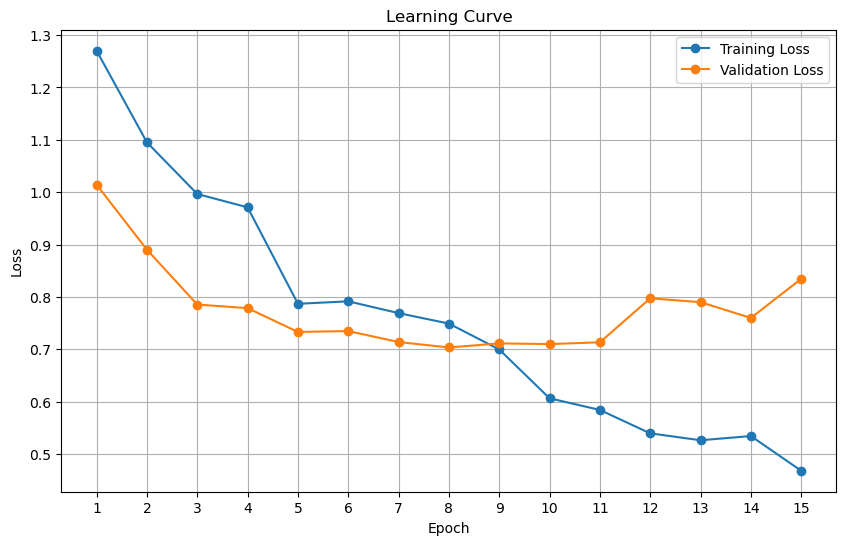

In [45]:
plt.figure(figsize=(10, 6))
epochs = range(1, training_args.num_train_epochs + 1)
if len(train_losses) >= training_args.num_train_epochs:
    plt.plot(epochs, train_losses[:training_args.num_train_epochs], label='Training Loss', marker='o')
if len(eval_losses) >= training_args.num_train_epochs:
    plt.plot(epochs, eval_losses[:training_args.num_train_epochs], label='Validation Loss', marker='o')

plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(epochs)
plt.show()

In [46]:
# run the prediction function
pred_labs_frozen = predict_nn(best_model, test_dataset)

gold_labs = test_dataset["label"]

In [47]:
f1 = f1_score(np.array(gold_labs).flatten(), pred_labs_frozen.flatten(), average='macro')
print(f'The best Model from Tuning F1 = {f1}')

The best Model from Tuning F1 = 0.7303085223441469


In [48]:
print(classification_report(np.array(gold_labs).flatten(), pred_labs_frozen.flatten()))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       558
           1       0.81      0.78      0.80       358
           2       0.52      0.50      0.51       123
           3       0.79      0.75      0.77       382

    accuracy                           0.78      1421
   macro avg       0.73      0.73      0.73      1421
weighted avg       0.78      0.78      0.78      1421



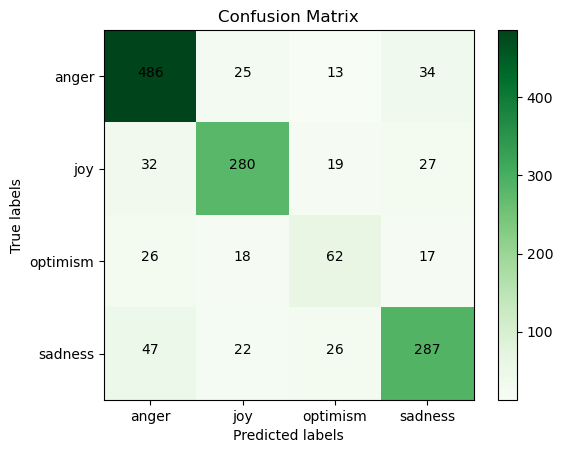

In [49]:
conf_matrix = confusion_matrix(np.array(gold_labs).flatten(), pred_labs_frozen.flatten())

# map emotion labels
emotion_labels = {0: 'anger', 1: 'joy', 2: 'optimism', 3: 'sadness'}

plt.figure()
plt.imshow(conf_matrix, cmap='Greens', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = range(len(conf_matrix))
plt.xticks(tick_marks, [emotion_labels[i] for i in range(len(conf_matrix))])
plt.yticks(tick_marks, [emotion_labels[i] for i in range(len(conf_matrix))])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# add counts in the matrix
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j, i, str(conf_matrix[i][j]), horizontalalignment='center', color='black')



In [50]:
fig = optuna.visualization.plot_slice(study, params=["learning_rate", "batch_size"])
fig.show()

In [51]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()